# Trash Classification - Experimental Analysis
#### Author: Rizky Azmi Swandy

## Downloading the Dataset

In [ ]:
import os
import time
from pathlib import Path
from datasets import load_dataset
import shutil
from tqdm.auto import tqdm
from PIL import Image
import torch
import numpy as np

# Create cache directory
CACHE_DIR = Path("./trash_data")
CACHE_DIR.mkdir(exist_ok=True)

print("Step 1: Downloading dataset from HuggingFace...")
start_time = time.time()
dataset = load_dataset("garythung/trashnet")
print(f"Initial download took: {time.time() - start_time:.2f} seconds")

# Save images locally
print("\nStep 2: Caching images locally...")
for split in ['train', 'validation', 'test']:
    # Create split directory
    split_dir = CACHE_DIR / split
    split_dir.mkdir(exist_ok=True)
    
    print(f"\nProcessing {split} set:")
    for idx, item in enumerate(tqdm(dataset[split])):
        # Get image and label
        img = item['image']  # This is a PIL Image
        label = item['label']
        
        # Save with proper naming
        save_path = split_dir / f"{idx:04d}_class{label}.jpg"
        img.save(str(save_path))  # Convert Path to string and save directly

print("\nStep 3: Verifying cached data...")
# Count files in each directory
for split in ['train', 'validation', 'test']:
    n_files = len(list((CACHE_DIR / split).glob("*.jpg")))
    n_original = len(dataset[split])
    print(f"{split}: {n_files} cached files (Original: {n_original})")

print("\nDataset cached successfully at:", CACHE_DIR.absolute())

## Hardware Configuration

In [1]:
import torch
import psutil
import GPUtil

# CPU Information
cpu_cores = psutil.cpu_count()
cpu_physical = psutil.cpu_count(logical=False)
ram = psutil.virtual_memory().total / (1024 ** 3)  # Convert to GB

print("CPU Configuration:")
print(f"Total CPU Cores: {cpu_cores}")
print(f"Physical CPU Cores: {cpu_physical}")
print(f"RAM: {ram:.2f} GB")
print(f"Using {min(24, cpu_cores)} worker threads for data loading")

# GPU Information
print("\nGPU Configuration:")
gpus = GPUtil.getGPUs()
for gpu in gpus:
    print(f"\nGPU {gpu.id}:")
    print(f"Name: {gpu.name}")
    print(f"Memory Total: {gpu.memoryTotal} MB")
    print(f"Memory Free: {gpu.memoryFree} MB")
    print(f"Memory Used: {gpu.memoryUsed} MB")
    print(f"GPU Load: {gpu.load*100}%")

# CUDA Configuration
print("\nCUDA Configuration:")
print(f"CUDA Available: {torch.cuda.is_available()}")
print(f"CUDA Version: {torch.version.cuda}")
if torch.cuda.is_available():
    for i in range(torch.cuda.device_count()):
        print(f"\nCUDA Device {i}:")
        print(f"Device Name: {torch.cuda.get_device_name(i)}")
        print(f"Total Memory: {torch.cuda.get_device_properties(i).total_memory / 1024**2:.2f} MB")

# Hardware-specific configurations
GPUS_TO_USE = [1, 2, 3]  # Using GPUs 2,3,4 (zero-indexed as 1,2,3)
NUM_WORKERS = min(24, cpu_cores)  # Maximum 24 workers as specified
BATCH_SIZE = 32 * len(GPUS_TO_USE)  # 32 samples per GPU

print("\nTraining Configuration:")
print(f"GPUs Used: {GPUS_TO_USE}")
print(f"Number of Workers: {NUM_WORKERS}")
print(f"Total Batch Size: {BATCH_SIZE}")

CPU Configuration:
Total CPU Cores: 48
Physical CPU Cores: 24
RAM: 125.53 GB
Using 24 worker threads for data loading

GPU Configuration:

GPU 0:
Name: NVIDIA GeForce RTX 2080 Ti
Memory Total: 11264.0 MB
Memory Free: 10681.0 MB
Memory Used: 323.0 MB
GPU Load: 0.0%

GPU 1:
Name: NVIDIA GeForce RTX 2080 Ti
Memory Total: 11264.0 MB
Memory Free: 9089.0 MB
Memory Used: 1915.0 MB
GPU Load: 0.0%

GPU 2:
Name: NVIDIA GeForce RTX 2080 Ti
Memory Total: 11264.0 MB
Memory Free: 9151.0 MB
Memory Used: 1853.0 MB
GPU Load: 0.0%

GPU 3:
Name: NVIDIA GeForce RTX 2080 Ti
Memory Total: 11264.0 MB
Memory Free: 9151.0 MB
Memory Used: 1853.0 MB
GPU Load: 0.0%

CUDA Configuration:
CUDA Available: True
CUDA Version: 12.4

CUDA Device 0:
Device Name: NVIDIA GeForce RTX 2080 Ti
Total Memory: 11004.50 MB

CUDA Device 1:
Device Name: NVIDIA GeForce RTX 2080 Ti
Total Memory: 11004.50 MB

CUDA Device 2:
Device Name: NVIDIA GeForce RTX 2080 Ti
Total Memory: 11004.50 MB

CUDA Device 3:
Device Name: NVIDIA GeForce RTX

## Setup and Dependencies

In [1]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
import torch.distributed as dist
from torch.utils.data import DataLoader, Dataset, random_split
from torchvision import transforms
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import seaborn as sns
from sklearn.metrics import confusion_matrix
import pandas as pd

from pathlib import Path
import time
from tqdm import tqdm

# Set random seeds for reproducibility
torch.manual_seed(42)
np.random.seed(42)

# GPU Configuration
os.environ["CUDA_VISIBLE_DEVICES"] = "1,2,3" 
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

## Data Loading and Initial Analysis

In [2]:
DATA_DIR = Path("./trash_data/train")  

print("Analyzing saved dataset...")
start_time = time.time()

# Get all image files
image_files = list(DATA_DIR.glob("*.jpg")) 
total_images = len(image_files)

print(f"\nFound {total_images} images in {DATA_DIR}")

# Quick analysis of the file naming pattern
print("\nAnalyzing file naming pattern...")
sample_files = sorted(image_files)[:5]
print("Sample filenames:")
for f in sample_files:
    print(f"  {f.name}")

# Count images per class (assuming class info is in filename)
class_counts = {}
for img_path in tqdm(image_files, desc="Counting classes"):
    class_id = int(img_path.stem.split('class')[-1])
    class_counts[class_id] = class_counts.get(class_id, 0) + 1

print("\nClass distribution:")
for class_id, count in sorted(class_counts.items()):
    print(f"Class {class_id}: {count} images")

print(f"\nAnalysis completed in {time.time() - start_time:.2f} seconds")

Analyzing saved dataset...

Found 5054 images in trash_data/train

Analyzing file naming pattern...
Sample filenames:
  0000_class0.jpg
  0001_class0.jpg
  0002_class0.jpg
  0003_class0.jpg
  0004_class0.jpg


Counting classes: 100%|██████████| 5054/5054 [00:00<00:00, 406520.52it/s]


Class distribution:
Class 0: 806 images
Class 1: 1002 images
Class 2: 820 images
Class 3: 1188 images
Class 4: 964 images
Class 5: 274 images

Analysis completed in 0.08 seconds


## Data Preparation and Augmentation


Analyzing image statistics...


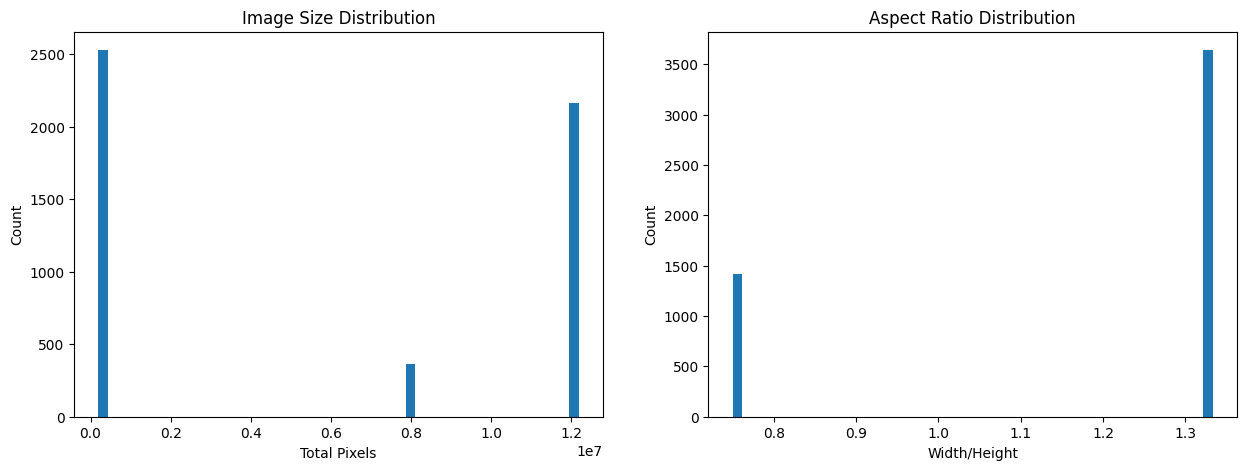

Average image size: 5892015 pixels
Average aspect ratio: 1.17

Splitting dataset of 5054 images into:
Training: 3537
Validation: 1010
Test: 507

Showing augmentation examples from training set:


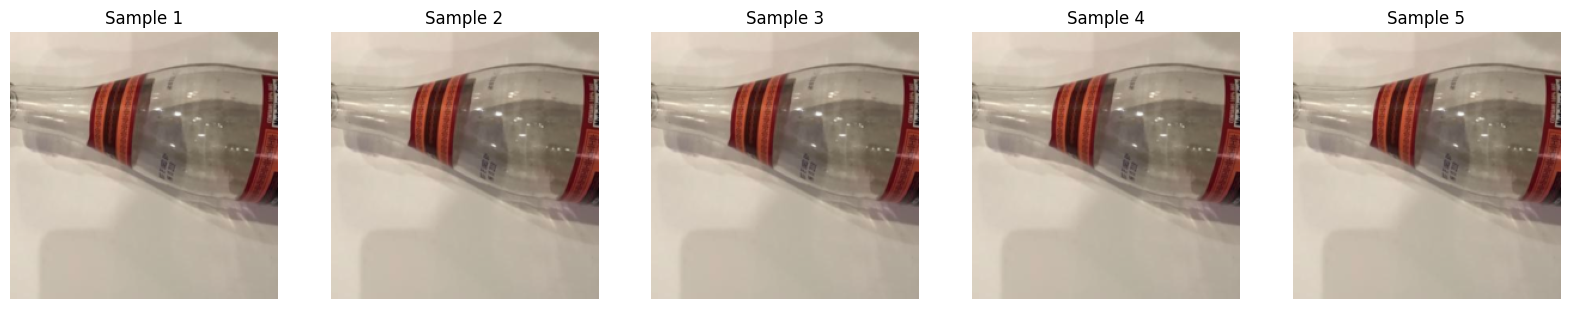

In [3]:
class TrashDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = Path(root_dir)
        self.transform = transform
        self.image_files = list(self.root_dir.glob("*.jpg"))
        self.analyze_image_stats()
    
    def analyze_image_stats(self):
        sizes = []
        aspect_ratios = []
        
        print("Analyzing image statistics...")
        for img_path in self.image_files:
            img = Image.open(img_path)
            w, h = img.size
            sizes.append(w * h)
            aspect_ratios.append(w/h)
        
        plt.figure(figsize=(15, 5))
        plt.subplot(1, 2, 1)
        plt.hist(sizes, bins=50)
        plt.title('Image Size Distribution')
        plt.xlabel('Total Pixels')
        plt.ylabel('Count')
        
        plt.subplot(1, 2, 2)
        plt.hist(aspect_ratios, bins=50)
        plt.title('Aspect Ratio Distribution')
        plt.xlabel('Width/Height')
        plt.ylabel('Count')
        plt.show()
        
        print(f"Average image size: {np.mean(sizes):.0f} pixels")
        print(f"Average aspect ratio: {np.mean(aspect_ratios):.2f}")
    
    def __len__(self):
        return len(self.image_files)
    
    def __getitem__(self, idx):
        img_path = self.image_files[idx]
        image = Image.open(img_path).convert('RGB')
        # Extract class from filename (adjust based on your naming convention)
        label = int(img_path.stem.split('class')[-1])
        
        if self.transform:
            image = self.transform(image)
        
        return image, label

# Define transforms
train_transform = transforms.Compose([
    transforms.RandomResizedCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
    transforms.ColorJitter(brightness=0.2, contrast=0.2),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                        std=[0.229, 0.224, 0.225])
])

val_transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                        std=[0.229, 0.224, 0.225])
])

# Create full dataset
full_dataset = TrashDataset("./trash_data/train", transform=None)  # No transform yet

# Calculate split sizes
total_size = len(full_dataset)
train_size = int(0.7 * total_size)
val_size = int(0.2 * total_size)
test_size = total_size - train_size - val_size

print(f"\nSplitting dataset of {total_size} images into:")
print(f"Training: {train_size}")
print(f"Validation: {val_size}")
print(f"Test: {test_size}")

# Split the dataset
train_dataset, val_dataset, test_dataset = random_split(
    full_dataset, 
    [train_size, val_size, test_size],
    generator=torch.Generator().manual_seed(42)  # For reproducibility
)

# Apply transforms to the splits
train_dataset.dataset.transform = train_transform
val_dataset.dataset.transform = val_transform
test_dataset.dataset.transform = val_transform

# Visualize augmentations
def show_augmentations(dataset, num_samples=5):
    plt.figure(figsize=(20, 4))
    for i in range(num_samples):
        img, label = dataset[0]  # Get same image
        img = img.permute(1, 2, 0).numpy()  # Convert to numpy for displaying
        img = (img - img.min()) / (img.max() - img.min())  # Denormalize
        
        plt.subplot(1, num_samples, i+1)
        plt.imshow(img)
        plt.title(f'Sample {i+1}')
        plt.axis('off')
    plt.show()

print("\nShowing augmentation examples from training set:")
show_augmentations(train_dataset)

### There are a few issues I notice:

1. Image Distribution shows two main spikes - suggesting we might have inconsistent image sizes in our dataset that need to be handled
2. Aspect Ratio Distribution shows one dominant ratio around 1.3 and another around 0.8, indicating inconsistency in image orientations
3. The augmentation examples are showing the same image 5 times with very minor variations, which doesn't properly demonstrate our augmentation strategy

### Let's modify the code to:

1. Add proper random sampling for augmentation visualization
2. Add class distribution analysis (which we can't see in the current output)
3. Add more diverse augmentations

Loading full dataset...
Analyzing dataset statistics...


Processing images:  24%|██▍       | 1203/5054 [00:00<00:00, 4113.42it/s]

Processing images: 100%|██████████| 5054/5054 [00:01<00:00, 4268.31it/s]


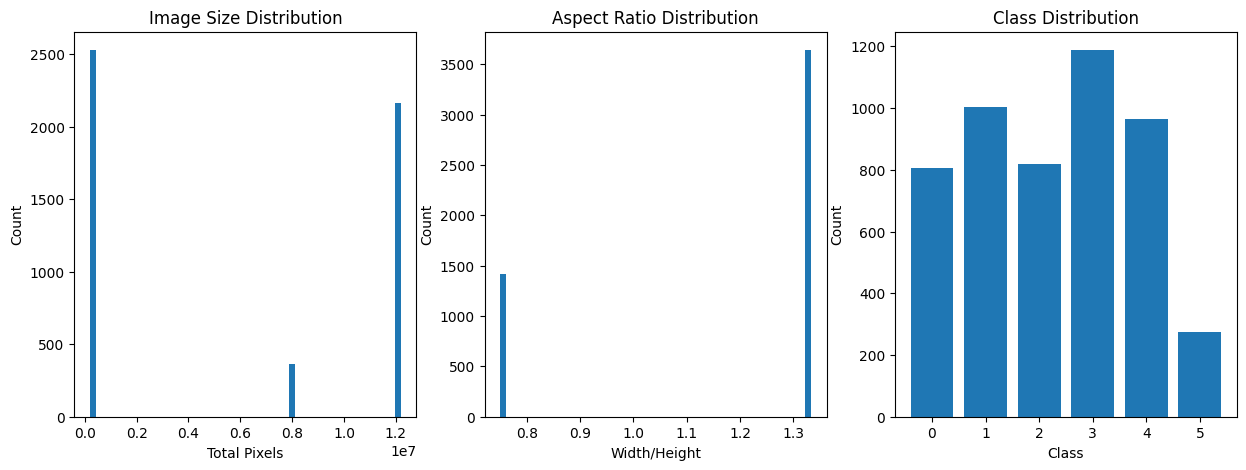


Dataset Statistics:
Average image size: 5892015 pixels
Average aspect ratio: 1.17

Class Distribution:
Class 0: 806 images (15.9%)
Class 1: 1002 images (19.8%)
Class 2: 820 images (16.2%)
Class 3: 1188 images (23.5%)
Class 4: 964 images (19.1%)
Class 5: 274 images (5.4%)

Splitting dataset of 5054 images into:
Training: 3537
Validation: 1010
Test: 507

Creating dataset splits...

Showing augmentation examples from training set:
Generating augmentation examples...


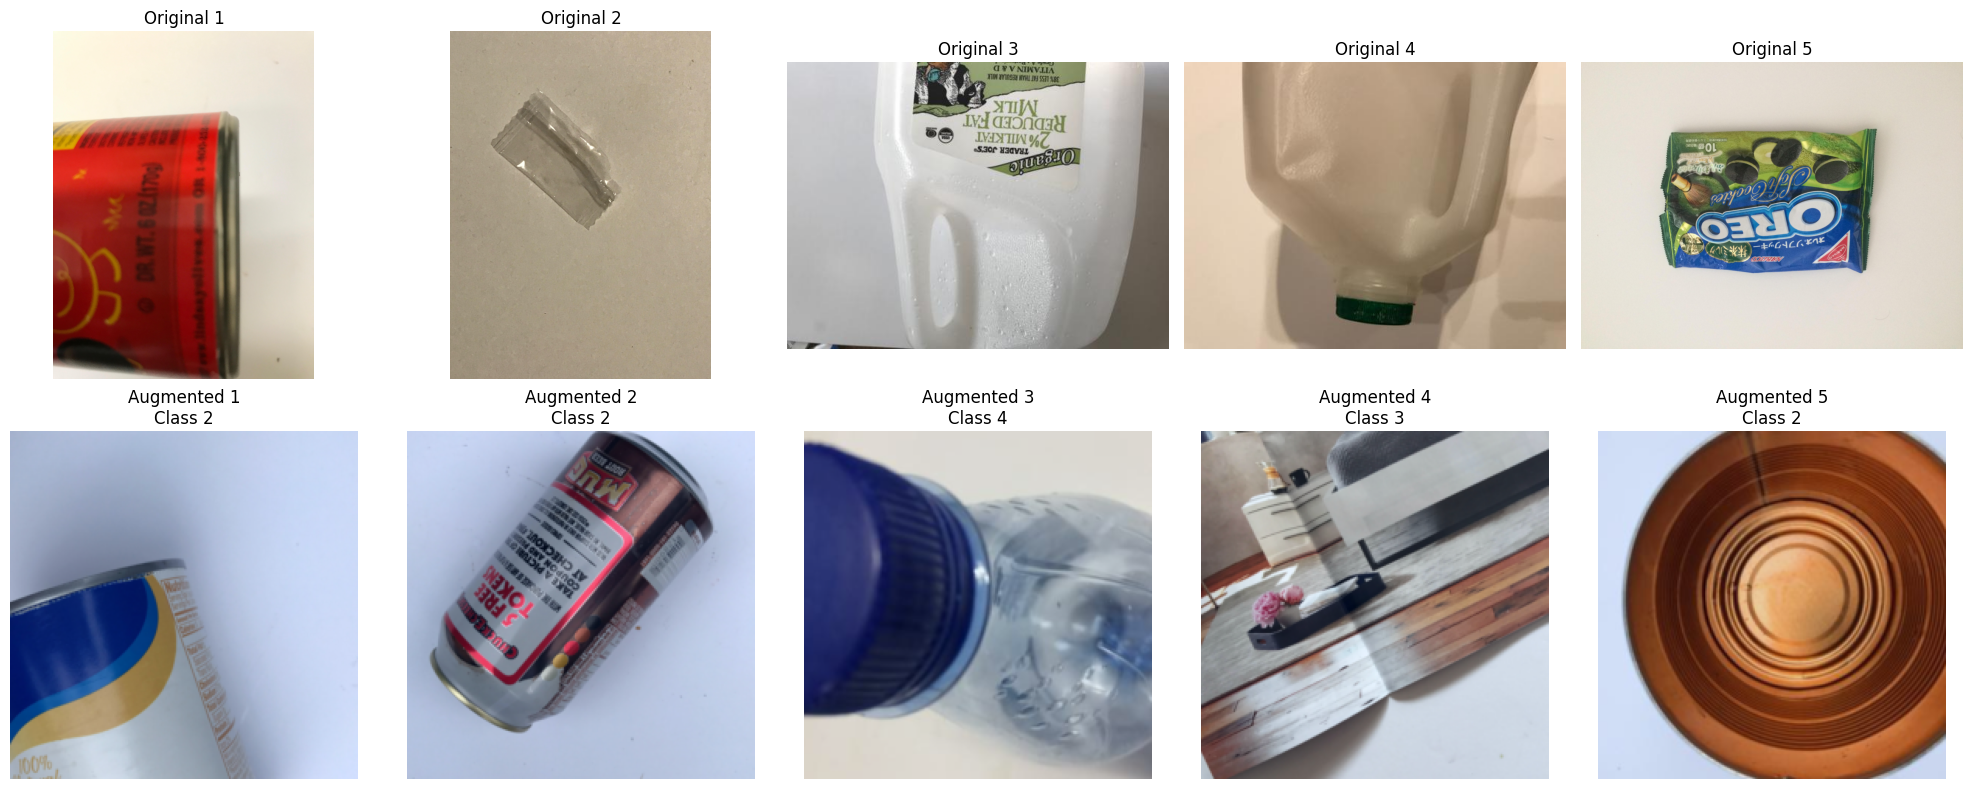

In [4]:
class TrashDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = Path(root_dir)
        self.transform = transform
        self.image_files = list(self.root_dir.glob("*.jpg"))
        self.analyze_dataset_stats()
    
    def analyze_dataset_stats(self):
        sizes = []
        aspect_ratios = []
        labels = []
        
        print("Analyzing dataset statistics...")
        for img_path in tqdm(self.image_files, desc="Processing images"):
            # Image stats
            img = Image.open(img_path)
            w, h = img.size
            sizes.append(w * h)
            aspect_ratios.append(w/h)
            
            # Class stats
            label = int(img_path.stem.split('class')[-1])
            labels.append(label)
        
        # Plot image statistics
        plt.figure(figsize=(15, 5))
        plt.subplot(1, 3, 1)
        plt.hist(sizes, bins=50)
        plt.title('Image Size Distribution')
        plt.xlabel('Total Pixels')
        plt.ylabel('Count')
        
        plt.subplot(1, 3, 2)
        plt.hist(aspect_ratios, bins=50)
        plt.title('Aspect Ratio Distribution')
        plt.xlabel('Width/Height')
        plt.ylabel('Count')
        
        # Plot class distribution
        unique_labels, counts = np.unique(labels, return_counts=True)
        plt.subplot(1, 3, 3)
        plt.bar(unique_labels, counts)
        plt.title('Class Distribution')
        plt.xlabel('Class')
        plt.ylabel('Count')
        plt.show()
        
        print(f"\nDataset Statistics:")
        print(f"Average image size: {np.mean(sizes):.0f} pixels")
        print(f"Average aspect ratio: {np.mean(aspect_ratios):.2f}")
        print("\nClass Distribution:")
        for label, count in zip(unique_labels, counts):
            print(f"Class {label}: {count} images ({count/len(labels)*100:.1f}%)")
    
    def __len__(self):
        return len(self.image_files)
    
    def __getitem__(self, idx):
        img_path = self.image_files[idx]
        image = Image.open(img_path).convert('RGB')
        label = int(img_path.stem.split('class')[-1])
        
        if self.transform:
            image = self.transform(image)
        
        return image, label

# Enhanced transforms with more augmentations
train_transform = transforms.Compose([
    transforms.RandomResizedCrop(224, scale=(0.8, 1.0)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(p=0.2),  # Added vertical flip
    transforms.RandomRotation(30),  # Increased rotation range
    transforms.RandomAffine(0, translate=(0.1, 0.1), scale=(0.9, 1.1)),  # Added affine transform
    transforms.ColorJitter(
        brightness=0.2,
        contrast=0.2,
        saturation=0.2,
        hue=0.1
    ),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                        std=[0.229, 0.224, 0.225])
])

val_transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                        std=[0.229, 0.224, 0.225])
])

# Create full dataset
print("Loading full dataset...")
full_dataset = TrashDataset("./trash_data/train", transform=None)

# Calculate split sizes
total_size = len(full_dataset)
train_size = int(0.7 * total_size)
val_size = int(0.2 * total_size)
test_size = total_size - train_size - val_size

print(f"\nSplitting dataset of {total_size} images into:")
print(f"Training: {train_size}")
print(f"Validation: {val_size}")
print(f"Test: {test_size}")

# Split the dataset
print("\nCreating dataset splits...")
train_dataset, val_dataset, test_dataset = random_split(
    full_dataset, 
    [train_size, val_size, test_size],
    generator=torch.Generator().manual_seed(42)
)

# Apply transforms
train_dataset.dataset.transform = train_transform
val_dataset.dataset.transform = val_transform
test_dataset.dataset.transform = val_transform

# Enhanced augmentation visualization
def show_augmentations(dataset, num_samples=5):
    print("Generating augmentation examples...")
    # Get random indices
    indices = torch.randperm(len(dataset))[:num_samples]
    
    plt.figure(figsize=(20, 8))
    # First row: original images
    for i, idx in enumerate(indices):
        img_path = dataset.dataset.image_files[idx]
        orig_img = Image.open(img_path).convert('RGB')
        plt.subplot(2, num_samples, i + 1)
        plt.imshow(orig_img)
        plt.title(f'Original {i+1}')
        plt.axis('off')
        
        # Second row: augmented images
        img, label = dataset[idx]
        img = img.permute(1, 2, 0).numpy()
        img = (img - img.min()) / (img.max() - img.min())
        plt.subplot(2, num_samples, i + num_samples + 1)
        plt.imshow(img)
        plt.title(f'Augmented {i+1}\nClass {label}')
        plt.axis('off')
    
    plt.tight_layout()
    plt.show()

print("\nShowing augmentation examples from training set:")
show_augmentations(train_dataset)

## Model Architecture

In [15]:
class TrashNet(nn.Module):
    def __init__(self, num_classes=6):
        super(TrashNet, self).__init__()
        
        # Simple sequential CNN with fewer layers but effective feature extraction
        self.features = nn.Sequential(
            # First conv block
            nn.Conv2d(3, 32, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2),
            
            # Second conv block
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2),
            
            # Third conv block
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2),
            
            # Global pooling
            nn.AdaptiveAvgPool2d((1, 1)),
            nn.Dropout(0.5)
        )
        
        # Simple classifier
        self.classifier = nn.Linear(128, num_classes)
    
    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)
        x = self.classifier(x)
        return x

In [16]:
print("Model Architecture:")
print(TrashNet())
print(f"\nTotal parameters: {sum(p.numel() for p in TrashNet().parameters()):,}")

Model Architecture:
TrashNet(
  (features): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (9): AdaptiveAvgPool2d(output_size=(1, 1))
    (10): Dropout(p=0.5, inplace=False)
  )
  (classifier): Linear(in_features=128, out_features=6, bias=True)
)

Total parameters: 94,022


## Training Setup and Implementation

Load data succeeded!
Calculated class weights for balanced loss
Starting training...


Validating: 100%|██████████| 6/6 [00:17<00:00,  2.93s/it]



Epoch 1/50:
Train Loss: 1.7600, Train Acc: 25.17%
Val Loss: 1.7037, Val Acc: 26.34%


Validating: 100%|██████████| 6/6 [00:17<00:00,  2.95s/it]



Epoch 2/50:
Train Loss: 1.6505, Train Acc: 33.83%
Val Loss: 1.5526, Val Acc: 37.52%


Validating: 100%|██████████| 6/6 [00:16<00:00,  2.83s/it]



Epoch 3/50:
Train Loss: 1.5515, Train Acc: 37.33%
Val Loss: 1.5182, Val Acc: 37.92%


Validating: 100%|██████████| 6/6 [00:16<00:00,  2.82s/it]



Epoch 4/50:
Train Loss: 1.5061, Train Acc: 39.73%
Val Loss: 1.4538, Val Acc: 38.02%


Validating: 100%|██████████| 6/6 [00:17<00:00,  2.90s/it]



Epoch 5/50:
Train Loss: 1.4612, Train Acc: 40.65%
Val Loss: 1.4172, Val Acc: 43.07%


Validating: 100%|██████████| 6/6 [00:17<00:00,  2.91s/it]



Epoch 6/50:
Train Loss: 1.4223, Train Acc: 42.33%
Val Loss: 1.3737, Val Acc: 44.26%


Validating: 100%|██████████| 6/6 [00:17<00:00,  2.86s/it]



Epoch 7/50:
Train Loss: 1.3778, Train Acc: 44.18%
Val Loss: 1.3462, Val Acc: 42.48%


Validating: 100%|██████████| 6/6 [00:17<00:00,  2.91s/it]



Epoch 8/50:
Train Loss: 1.3447, Train Acc: 44.01%
Val Loss: 1.2877, Val Acc: 48.71%


Validating: 100%|██████████| 6/6 [00:16<00:00,  2.75s/it]



Epoch 9/50:
Train Loss: 1.2750, Train Acc: 48.03%
Val Loss: 1.2539, Val Acc: 50.00%


Validating: 100%|██████████| 6/6 [00:17<00:00,  2.96s/it]



Epoch 10/50:
Train Loss: 1.2897, Train Acc: 48.44%
Val Loss: 1.2396, Val Acc: 50.40%


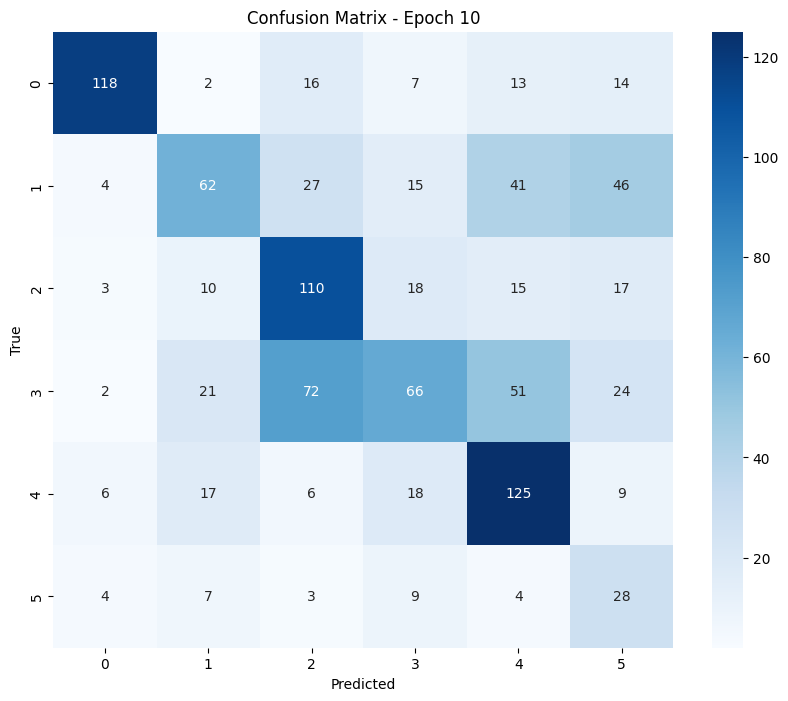

Validating: 100%|██████████| 6/6 [00:17<00:00,  2.85s/it]



Epoch 11/50:
Train Loss: 1.2389, Train Acc: 50.69%
Val Loss: 1.1976, Val Acc: 50.00%


Validating: 100%|██████████| 6/6 [00:16<00:00,  2.83s/it]



Epoch 12/50:
Train Loss: 1.2370, Train Acc: 50.00%
Val Loss: 1.2376, Val Acc: 51.39%


Validating: 100%|██████████| 6/6 [00:17<00:00,  2.88s/it]



Epoch 13/50:
Train Loss: 1.2434, Train Acc: 51.19%
Val Loss: 1.1628, Val Acc: 50.69%


Validating: 100%|██████████| 6/6 [00:16<00:00,  2.82s/it]



Epoch 14/50:
Train Loss: 1.2150, Train Acc: 51.88%
Val Loss: 1.1602, Val Acc: 55.64%


Validating: 100%|██████████| 6/6 [00:17<00:00,  2.89s/it]



Epoch 15/50:
Train Loss: 1.1756, Train Acc: 53.59%
Val Loss: 1.1753, Val Acc: 53.96%


Validating: 100%|██████████| 6/6 [00:17<00:00,  2.88s/it]



Epoch 16/50:
Train Loss: 1.1843, Train Acc: 54.05%
Val Loss: 1.1205, Val Acc: 56.83%


Validating: 100%|██████████| 6/6 [00:17<00:00,  2.87s/it]



Epoch 17/50:
Train Loss: 1.1441, Train Acc: 54.54%
Val Loss: 1.1447, Val Acc: 57.92%


Validating: 100%|██████████| 6/6 [00:18<00:00,  3.01s/it]



Epoch 18/50:
Train Loss: 1.1128, Train Acc: 56.77%
Val Loss: 1.0624, Val Acc: 59.50%


Validating: 100%|██████████| 6/6 [00:17<00:00,  2.94s/it]



Epoch 19/50:
Train Loss: 1.1295, Train Acc: 56.71%
Val Loss: 1.0752, Val Acc: 58.32%


Validating: 100%|██████████| 6/6 [00:17<00:00,  2.94s/it]



Epoch 20/50:
Train Loss: 1.0774, Train Acc: 58.33%
Val Loss: 1.0350, Val Acc: 61.29%


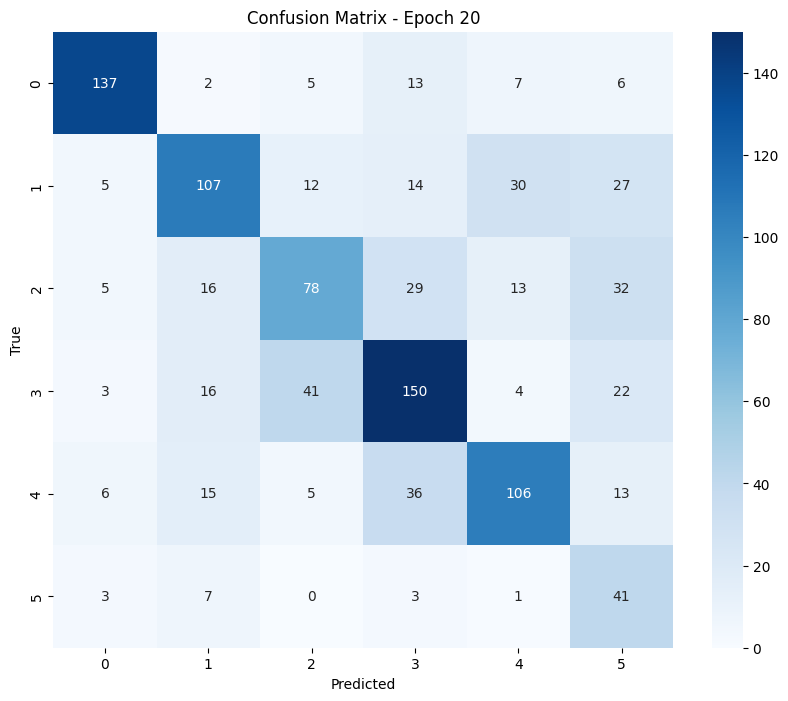

Validating: 100%|██████████| 6/6 [00:17<00:00,  2.94s/it]



Epoch 21/50:
Train Loss: 1.0610, Train Acc: 59.00%
Val Loss: 1.0298, Val Acc: 59.11%


Validating: 100%|██████████| 6/6 [00:17<00:00,  2.91s/it]



Epoch 22/50:
Train Loss: 1.0690, Train Acc: 59.00%
Val Loss: 1.0451, Val Acc: 62.08%


Validating: 100%|██████████| 6/6 [00:17<00:00,  2.92s/it]



Epoch 23/50:
Train Loss: 1.0507, Train Acc: 59.20%
Val Loss: 0.9901, Val Acc: 64.36%


Validating: 100%|██████████| 6/6 [00:17<00:00,  2.89s/it]



Epoch 24/50:
Train Loss: 1.0214, Train Acc: 61.40%
Val Loss: 0.9872, Val Acc: 61.39%


Validating: 100%|██████████| 6/6 [00:17<00:00,  2.83s/it]



Epoch 25/50:
Train Loss: 0.9975, Train Acc: 61.14%
Val Loss: 0.9604, Val Acc: 62.97%


Validating: 100%|██████████| 6/6 [00:17<00:00,  2.93s/it]



Epoch 26/50:
Train Loss: 0.9845, Train Acc: 62.24%
Val Loss: 1.0799, Val Acc: 64.26%


Validating: 100%|██████████| 6/6 [00:17<00:00,  2.98s/it]



Epoch 27/50:
Train Loss: 0.9568, Train Acc: 63.72%
Val Loss: 0.9503, Val Acc: 67.82%


Validating: 100%|██████████| 6/6 [00:17<00:00,  2.85s/it]



Epoch 28/50:
Train Loss: 0.9721, Train Acc: 62.93%
Val Loss: 0.9940, Val Acc: 64.26%


Validating: 100%|██████████| 6/6 [00:16<00:00,  2.82s/it]



Epoch 29/50:
Train Loss: 0.9499, Train Acc: 64.41%
Val Loss: 0.9275, Val Acc: 64.36%


Validating: 100%|██████████| 6/6 [00:17<00:00,  2.84s/it]



Epoch 30/50:
Train Loss: 0.9390, Train Acc: 64.73%
Val Loss: 0.9263, Val Acc: 68.22%


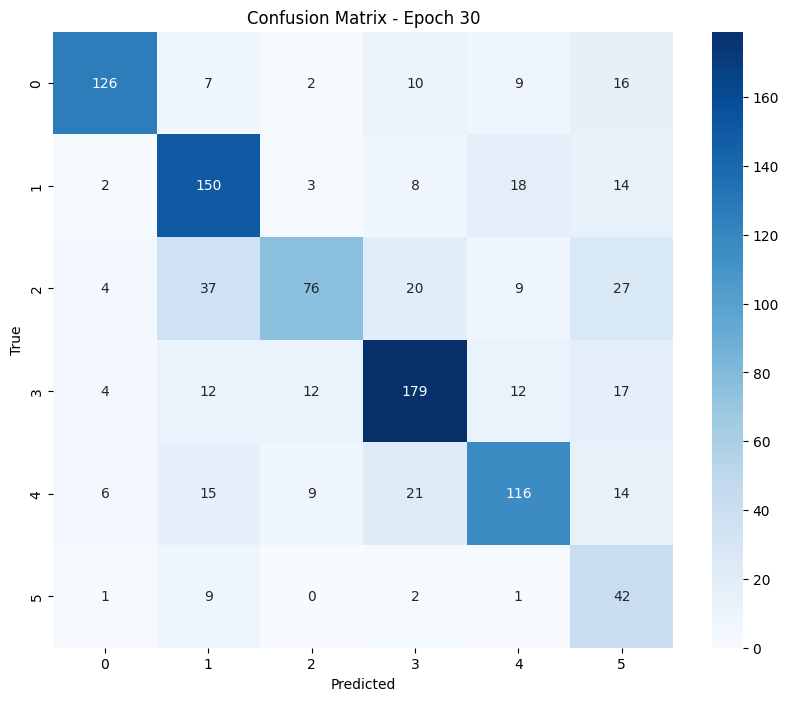

Validating: 100%|██████████| 6/6 [00:17<00:00,  2.87s/it]



Epoch 31/50:
Train Loss: 0.9038, Train Acc: 65.71%
Val Loss: 0.8975, Val Acc: 68.22%


Validating: 100%|██████████| 6/6 [00:17<00:00,  2.92s/it]



Epoch 32/50:
Train Loss: 0.9023, Train Acc: 66.75%
Val Loss: 0.8760, Val Acc: 69.90%


Validating: 100%|██████████| 6/6 [00:18<00:00,  3.04s/it]



Epoch 33/50:
Train Loss: 0.8802, Train Acc: 67.42%
Val Loss: 0.8524, Val Acc: 70.50%


Validating: 100%|██████████| 6/6 [00:17<00:00,  2.97s/it]



Epoch 34/50:
Train Loss: 0.8665, Train Acc: 68.43%
Val Loss: 0.8336, Val Acc: 68.61%


Validating: 100%|██████████| 6/6 [00:17<00:00,  2.93s/it]



Epoch 35/50:
Train Loss: 0.8486, Train Acc: 68.37%
Val Loss: 0.8274, Val Acc: 69.50%


Validating: 100%|██████████| 6/6 [00:17<00:00,  2.93s/it]



Epoch 36/50:
Train Loss: 0.8511, Train Acc: 67.48%
Val Loss: 0.8307, Val Acc: 68.32%


Validating: 100%|██████████| 6/6 [00:17<00:00,  2.94s/it]



Epoch 37/50:
Train Loss: 0.8381, Train Acc: 69.21%
Val Loss: 0.8338, Val Acc: 69.70%


Validating: 100%|██████████| 6/6 [00:18<00:00,  3.03s/it]



Epoch 38/50:
Train Loss: 0.8142, Train Acc: 69.39%
Val Loss: 0.7960, Val Acc: 73.07%


Validating: 100%|██████████| 6/6 [00:17<00:00,  2.96s/it]



Epoch 39/50:
Train Loss: 0.8094, Train Acc: 69.33%
Val Loss: 0.7917, Val Acc: 74.06%


Validating: 100%|██████████| 6/6 [00:17<00:00,  2.90s/it]



Epoch 40/50:
Train Loss: 0.8079, Train Acc: 70.25%
Val Loss: 0.8008, Val Acc: 70.79%


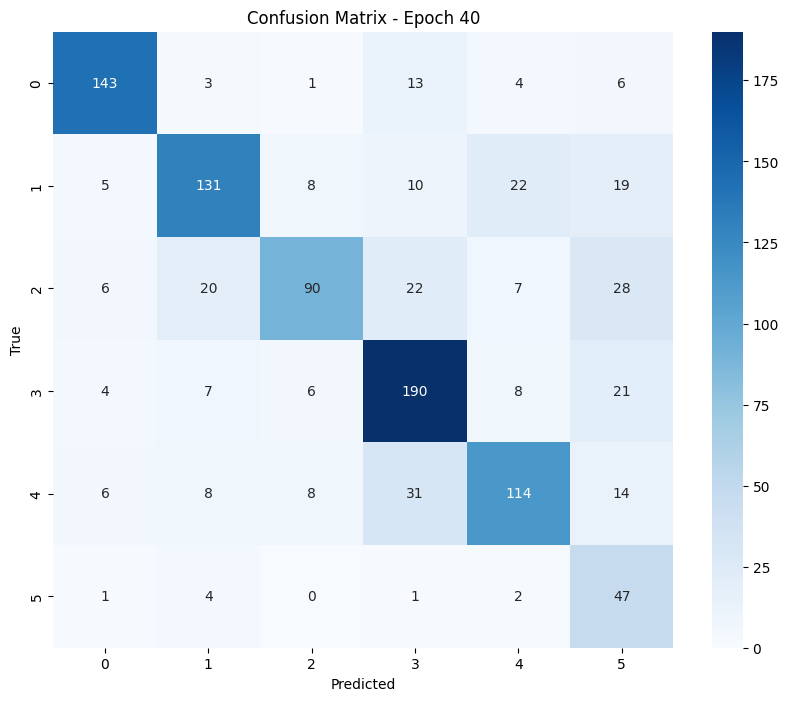

Validating: 100%|██████████| 6/6 [00:17<00:00,  2.90s/it]



Epoch 41/50:
Train Loss: 0.8032, Train Acc: 70.34%
Val Loss: 0.8033, Val Acc: 73.96%


Validating: 100%|██████████| 6/6 [00:17<00:00,  2.85s/it]



Epoch 42/50:
Train Loss: 0.7824, Train Acc: 71.01%
Val Loss: 0.7780, Val Acc: 72.38%


Validating: 100%|██████████| 6/6 [00:17<00:00,  2.97s/it]



Epoch 43/50:
Train Loss: 0.7872, Train Acc: 71.70%
Val Loss: 0.7730, Val Acc: 72.97%


Validating: 100%|██████████| 6/6 [00:18<00:00,  3.02s/it]



Epoch 44/50:
Train Loss: 0.7658, Train Acc: 71.24%
Val Loss: 0.7649, Val Acc: 73.86%


Validating: 100%|██████████| 6/6 [00:17<00:00,  2.90s/it]



Epoch 45/50:
Train Loss: 0.7726, Train Acc: 71.99%
Val Loss: 0.7659, Val Acc: 73.37%


Validating: 100%|██████████| 6/6 [00:17<00:00,  2.90s/it]



Epoch 46/50:
Train Loss: 0.7611, Train Acc: 71.79%
Val Loss: 0.7533, Val Acc: 74.55%


Validating: 100%|██████████| 6/6 [00:18<00:00,  3.00s/it]



Epoch 47/50:
Train Loss: 0.7684, Train Acc: 72.28%
Val Loss: 0.7563, Val Acc: 73.56%


Validating: 100%|██████████| 6/6 [00:17<00:00,  2.92s/it]



Epoch 48/50:
Train Loss: 0.7674, Train Acc: 71.73%
Val Loss: 0.7568, Val Acc: 73.96%


Validating: 100%|██████████| 6/6 [00:17<00:00,  2.94s/it]



Epoch 49/50:
Train Loss: 0.7602, Train Acc: 71.85%
Val Loss: 0.7555, Val Acc: 74.16%


Validating: 100%|██████████| 6/6 [00:17<00:00,  2.97s/it]



Epoch 50/50:
Train Loss: 0.7591, Train Acc: 72.11%
Val Loss: 0.7555, Val Acc: 74.26%


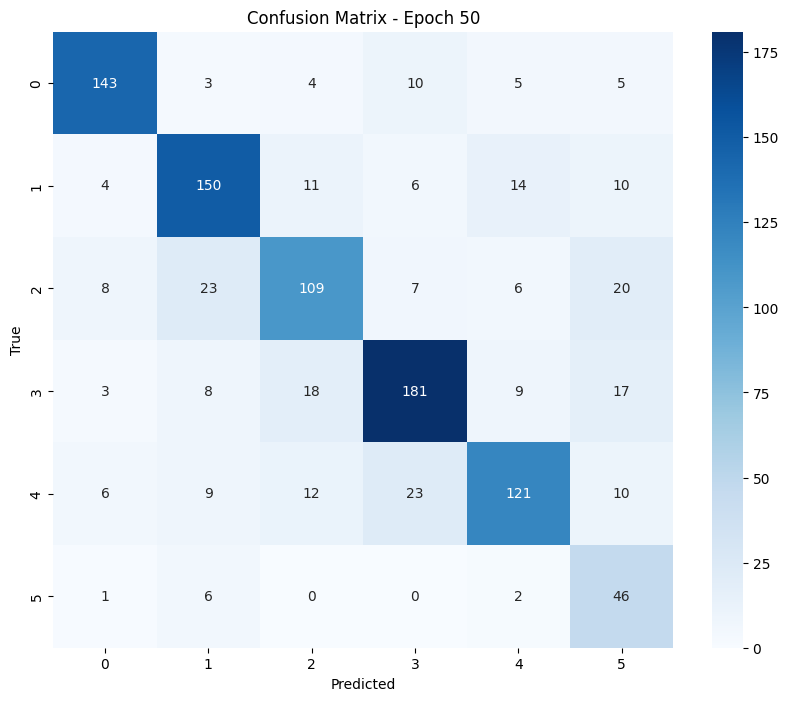

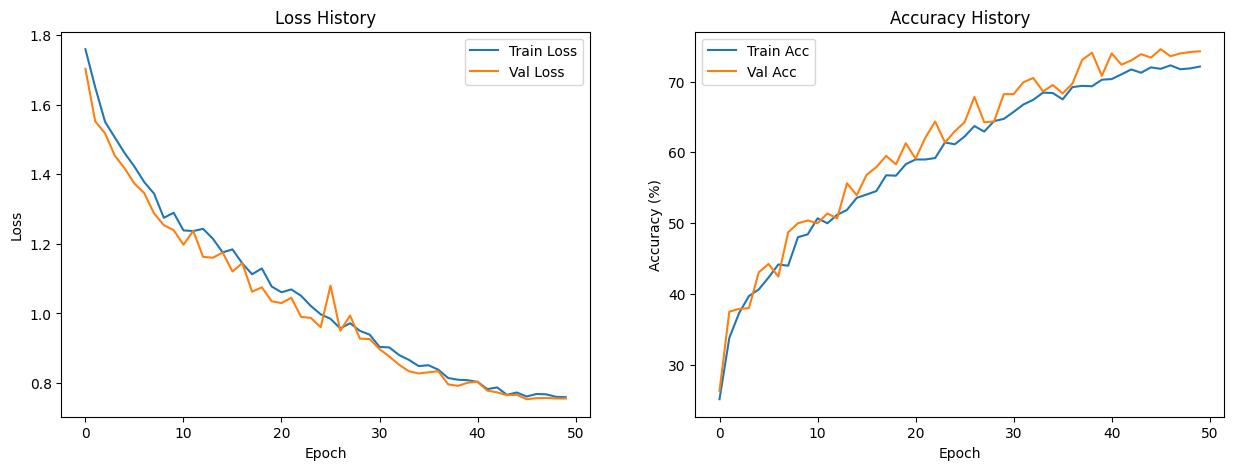


Evaluating best model on test set...


/tmp/ipykernel_4161276/1298066049.py:212: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load('best_model.pth')


NameError: name 'test_loader' is not defined

In [18]:
# Device setup for 3 GPUs
GPUS_TO_USE = [1, 2, 3]  # Keep your original GPU setup
n_gpus = len(GPUS_TO_USE)
device = f'cuda:{GPUS_TO_USE[0]}'
torch.cuda.set_device(GPUS_TO_USE[0])

# Model initialization with multi-GPU support
model = TrashNet()
model = model.to(device)
if n_gpus > 1:
    model = torch.nn.DataParallel(model, device_ids=GPUS_TO_USE)

# Adjusted hyperparameters for multi-GPU training
batch_size_per_gpu = 64  # Increased batch size per GPU for SimpleTrashNet
batch_size = batch_size_per_gpu * n_gpus  # Total batch size across all GPUs
num_epochs = 50  # Kept reduced epochs due to simpler model
initial_lr = 0.0003 * n_gpus  # Scale learning rate with number of GPUs
max_lr = initial_lr * 5
patience = 7

# Data Loaders - Keep high number of workers for multiple GPUs
train_loader = DataLoader(
    train_dataset,
    batch_size=batch_size,
    shuffle=True,
    num_workers=24,  # Kept original worker count for multi-GPU
    pin_memory=True,
    drop_last=True
)

val_loader = DataLoader(
    val_dataset,
    batch_size=batch_size,
    shuffle=False,
    num_workers=24,
    pin_memory=True
)
print("Load data succeeded!")

# Calculate class weights for balanced loss
class_counts = torch.bincount(torch.tensor([y for _, y in train_dataset]))
weights = 1. / class_counts.float()
weights = weights / weights.sum()
weights = weights.to(device)
print("Calculated class weights for balanced loss")

# Loss and optimizer
criterion = nn.CrossEntropyLoss(weight=weights)
optimizer = optim.AdamW(model.parameters(), lr=initial_lr, weight_decay=0.01)
scheduler = optim.lr_scheduler.OneCycleLR(
    optimizer,
    max_lr=max_lr,
    div_factor=10,
    final_div_factor=1000,
    epochs=num_epochs,
    steps_per_epoch=len(train_loader)
)

def train_epoch(model, loader, criterion, optimizer, scheduler, epoch):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    
    pbar = tqdm(loader, desc=f'Epoch {epoch+1}/{num_epochs}')
    for batch_idx, (images, targets) in enumerate(pbar):
        images, targets = images.to(device), targets.to(device)
        
        # Forward pass
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, targets)
        
        # Backward pass
        loss.backward()
        optimizer.step()
        scheduler.step()
        
        # Statistics
        running_loss += loss.item()
        _, predicted = outputs.max(1)
        total += targets.size(0)
        correct += predicted.eq(targets).sum().item()
        
        # Update progress bar
        acc = 100. * correct / total
        pbar.set_postfix({
            'loss': f'{loss.item():.4f}',
            'acc': f'{acc:.2f}%',
            'lr': f'{scheduler.get_last_lr()[0]:.6f}'
        })
    
    epoch_loss = running_loss / len(loader)
    epoch_acc = 100. * correct / total
    return epoch_loss, epoch_acc

def validate(model, loader, criterion):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0
    all_preds = []
    all_targets = []
    
    with torch.no_grad():
        for images, targets in tqdm(loader, desc='Validating'):
            images, targets = images.to(device), targets.to(device)
            
            outputs = model(images)
            loss = criterion(outputs, targets)
            
            running_loss += loss.item()
            _, predicted = outputs.max(1)
            total += targets.size(0)
            correct += predicted.eq(targets).sum().item()
            
            all_preds.extend(predicted.cpu().numpy())
            all_targets.extend(targets.cpu().numpy())
    
    val_loss = running_loss / len(loader)
    val_acc = 100. * correct / total
    return val_loss, val_acc, all_preds, all_targets

def save_checkpoint(model, optimizer, scheduler, epoch, metrics, filename):
    checkpoint = {
        'epoch': epoch,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'scheduler_state_dict': scheduler.state_dict(),
        'metrics': metrics
    }
    torch.save(checkpoint, filename)

# Training execution
print("Starting training...")
train_losses = []
train_accs = []
val_losses = []
val_accs = []
best_val_acc = 0
early_stopping_counter = 0
min_val_loss = float('inf')

for epoch in range(num_epochs):
    # Training phase
    train_loss, train_acc = train_epoch(model, train_loader, criterion, 
                                      optimizer, scheduler, epoch)
    train_losses.append(train_loss)
    train_accs.append(train_acc)
    
    # Validation phase
    val_loss, val_acc, preds, targets = validate(model, val_loader, criterion)
    val_losses.append(val_loss)
    val_accs.append(val_acc)
    
    # Print epoch summary
    print(f'\nEpoch {epoch+1}/{num_epochs}:')
    print(f'Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}%')
    print(f'Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.2f}%')
    
    # Save best model
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        metrics = {
            'train_loss': train_loss,
            'train_acc': train_acc,
            'val_loss': val_loss,
            'val_acc': val_acc,
            'best_val_acc': best_val_acc
        }
        save_checkpoint(model, optimizer, scheduler, epoch, metrics, 'best_model.pth')
        early_stopping_counter = 0
    else:
        early_stopping_counter += 1
    
    # Early stopping check
    if early_stopping_counter >= patience:
        print(f'\nEarly stopping triggered after {epoch+1} epochs')
        break
    
    # Plot confusion matrix every 10 epochs
    if (epoch + 1) % 10 == 0:
        cm = confusion_matrix(targets, preds)
        plt.figure(figsize=(10, 8))
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
        plt.title(f'Confusion Matrix - Epoch {epoch+1}')
        plt.xlabel('Predicted')
        plt.ylabel('True')
        plt.show()

# Plot final training curves
plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Val Loss')
plt.title('Loss History')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(train_accs, label='Train Acc')
plt.plot(val_accs, label='Val Acc')
plt.title('Accuracy History')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.legend()
plt.show()

#### Improving the TrashNet Model after bad loss and accuracy.

In [13]:

class ImprovedTrashNet(nn.Module):
    def __init__(self, num_classes=6):
        super(ImprovedTrashNet, self).__init__()
        
        self.features = nn.Sequential(
            # First block - more filters
            nn.Conv2d(3, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),  # Added BatchNorm
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2),
            
            # Second block
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2),
            
            # Third block
            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2),
            
            # Fourth block for more feature extraction
            nn.Conv2d(256, 512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2),
            
            nn.AdaptiveAvgPool2d((1, 1)),
            nn.Dropout(0.4)  # Slightly reduced dropout
        )
        
        self.classifier = nn.Sequential(
            nn.Linear(512, 256),
            nn.ReLU(inplace=True),
            nn.Dropout(0.4),
            nn.Linear(256, num_classes)
        )
        
    def forward(self, x):
        # Pass through feature extraction layers
        x = self.features(x)
        
        # Flatten the features
        x = torch.flatten(x, 1)  # Flatten all dimensions except batch (more explicit than view)
        
        # Pass through classifier
        x = self.classifier(x)
        return x

### Train Again with new architecture with improved network layer

Available GPUs: 3
Using 3 GPUs: [0, 1, 2]
Successfully initialized DataParallel
Total batch size: 96
Initial learning rate: 0.0001


Starting training...


Validating: 100%|██████████| 11/11 [00:10<00:00,  1.02it/s]



Epoch 1/100:
Train Loss: 1.7220, Train Acc: 31.54%
Val Loss: 1.6322, Val Acc: 42.87%


Validating: 100%|██████████| 11/11 [00:10<00:00,  1.05it/s]



Epoch 2/100:
Train Loss: 1.5767, Train Acc: 42.04%
Val Loss: 1.4795, Val Acc: 46.14%


Validating: 100%|██████████| 11/11 [00:11<00:00,  1.02s/it]



Epoch 3/100:
Train Loss: 1.4830, Train Acc: 48.09%
Val Loss: 1.4066, Val Acc: 49.21%


Validating: 100%|██████████| 11/11 [00:11<00:00,  1.00s/it]



Epoch 4/100:
Train Loss: 1.4206, Train Acc: 49.71%
Val Loss: 1.3400, Val Acc: 51.58%


Validating: 100%|██████████| 11/11 [00:10<00:00,  1.04it/s]



Epoch 5/100:
Train Loss: 1.3759, Train Acc: 53.07%
Val Loss: 1.3063, Val Acc: 54.65%


Validating: 100%|██████████| 11/11 [00:11<00:00,  1.02s/it]



Epoch 6/100:
Train Loss: 1.3363, Train Acc: 56.02%
Val Loss: 1.2825, Val Acc: 59.60%


Validating: 100%|██████████| 11/11 [00:10<00:00,  1.04it/s]



Epoch 7/100:
Train Loss: 1.3259, Train Acc: 55.79%
Val Loss: 1.2429, Val Acc: 61.98%


Validating: 100%|██████████| 11/11 [00:10<00:00,  1.05it/s]



Epoch 8/100:
Train Loss: 1.2844, Train Acc: 58.25%
Val Loss: 1.2682, Val Acc: 60.69%


Validating: 100%|██████████| 11/11 [00:11<00:00,  1.05s/it]



Epoch 9/100:
Train Loss: 1.2565, Train Acc: 59.90%
Val Loss: 1.2262, Val Acc: 65.05%


Validating: 100%|██████████| 11/11 [00:11<00:00,  1.06s/it]



Epoch 10/100:
Train Loss: 1.2334, Train Acc: 62.30%
Val Loss: 1.1959, Val Acc: 58.61%


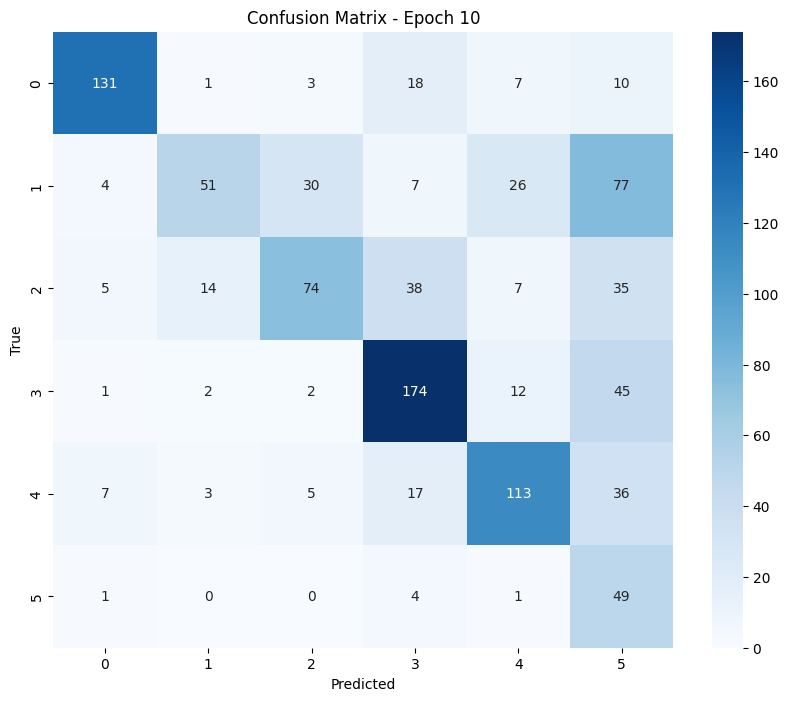

Validating: 100%|██████████| 11/11 [00:11<00:00,  1.08s/it]



Epoch 11/100:
Train Loss: 1.2442, Train Acc: 61.52%
Val Loss: 1.2617, Val Acc: 59.70%


Validating: 100%|██████████| 11/11 [00:11<00:00,  1.04s/it]



Epoch 12/100:
Train Loss: 1.2150, Train Acc: 63.54%
Val Loss: 1.1459, Val Acc: 65.15%


Validating: 100%|██████████| 11/11 [00:12<00:00,  1.10s/it]



Epoch 13/100:
Train Loss: 1.2230, Train Acc: 63.72%
Val Loss: 1.1804, Val Acc: 64.16%


Validating: 100%|██████████| 11/11 [00:11<00:00,  1.04s/it]



Epoch 14/100:
Train Loss: 1.1938, Train Acc: 64.81%
Val Loss: 1.4319, Val Acc: 57.52%


Validating: 100%|██████████| 11/11 [00:11<00:00,  1.04s/it]



Epoch 15/100:
Train Loss: 1.1934, Train Acc: 64.90%
Val Loss: 1.1637, Val Acc: 62.57%


Validating: 100%|██████████| 11/11 [00:11<00:00,  1.05s/it]



Epoch 16/100:
Train Loss: 1.1807, Train Acc: 66.44%
Val Loss: 1.2138, Val Acc: 61.29%


Validating: 100%|██████████| 11/11 [00:12<00:00,  1.11s/it]



Epoch 17/100:
Train Loss: 1.1498, Train Acc: 67.97%
Val Loss: 1.2156, Val Acc: 59.41%


Validating: 100%|██████████| 11/11 [00:11<00:00,  1.06s/it]



Epoch 18/100:
Train Loss: 1.1363, Train Acc: 68.03%
Val Loss: 1.1448, Val Acc: 65.74%


Validating: 100%|██████████| 11/11 [00:11<00:00,  1.03s/it]



Epoch 19/100:
Train Loss: 1.1551, Train Acc: 67.88%
Val Loss: 1.2389, Val Acc: 64.85%


Validating: 100%|██████████| 11/11 [00:11<00:00,  1.05s/it]



Epoch 20/100:
Train Loss: 1.1334, Train Acc: 69.33%
Val Loss: 1.4754, Val Acc: 55.64%


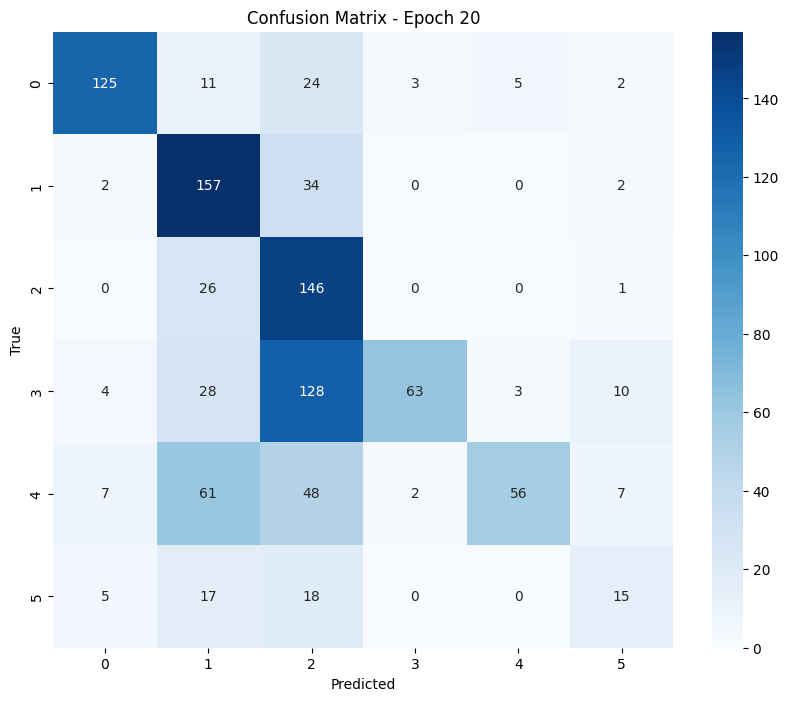

Validating: 100%|██████████| 11/11 [00:11<00:00,  1.08s/it]



Epoch 21/100:
Train Loss: 1.1127, Train Acc: 70.25%
Val Loss: 1.1038, Val Acc: 71.39%


Validating: 100%|██████████| 11/11 [00:11<00:00,  1.03s/it]



Epoch 22/100:
Train Loss: 1.0897, Train Acc: 71.64%
Val Loss: 1.0876, Val Acc: 68.12%


Validating: 100%|██████████| 11/11 [00:11<00:00,  1.00s/it]



Epoch 23/100:
Train Loss: 1.0979, Train Acc: 70.98%
Val Loss: 1.1223, Val Acc: 67.72%


Validating: 100%|██████████| 11/11 [00:12<00:00,  1.11s/it]



Epoch 24/100:
Train Loss: 1.0793, Train Acc: 72.74%
Val Loss: 1.1863, Val Acc: 69.90%


Validating: 100%|██████████| 11/11 [00:11<00:00,  1.06s/it]



Epoch 25/100:
Train Loss: 1.0684, Train Acc: 73.09%
Val Loss: 1.1820, Val Acc: 64.06%


Validating: 100%|██████████| 11/11 [00:11<00:00,  1.06s/it]



Epoch 26/100:
Train Loss: 1.0617, Train Acc: 73.78%
Val Loss: 1.0901, Val Acc: 69.60%


Validating: 100%|██████████| 11/11 [00:11<00:00,  1.04s/it]



Epoch 27/100:
Train Loss: 1.0505, Train Acc: 74.31%
Val Loss: 0.9990, Val Acc: 75.64%


Validating: 100%|██████████| 11/11 [00:12<00:00,  1.10s/it]



Epoch 28/100:
Train Loss: 1.0506, Train Acc: 74.39%
Val Loss: 1.4728, Val Acc: 50.00%


Validating: 100%|██████████| 11/11 [00:11<00:00,  1.03s/it]



Epoch 29/100:
Train Loss: 1.0320, Train Acc: 74.54%
Val Loss: 1.0453, Val Acc: 78.22%


Validating: 100%|██████████| 11/11 [00:11<00:00,  1.00s/it]



Epoch 30/100:
Train Loss: 1.0398, Train Acc: 74.36%
Val Loss: 1.1185, Val Acc: 72.87%


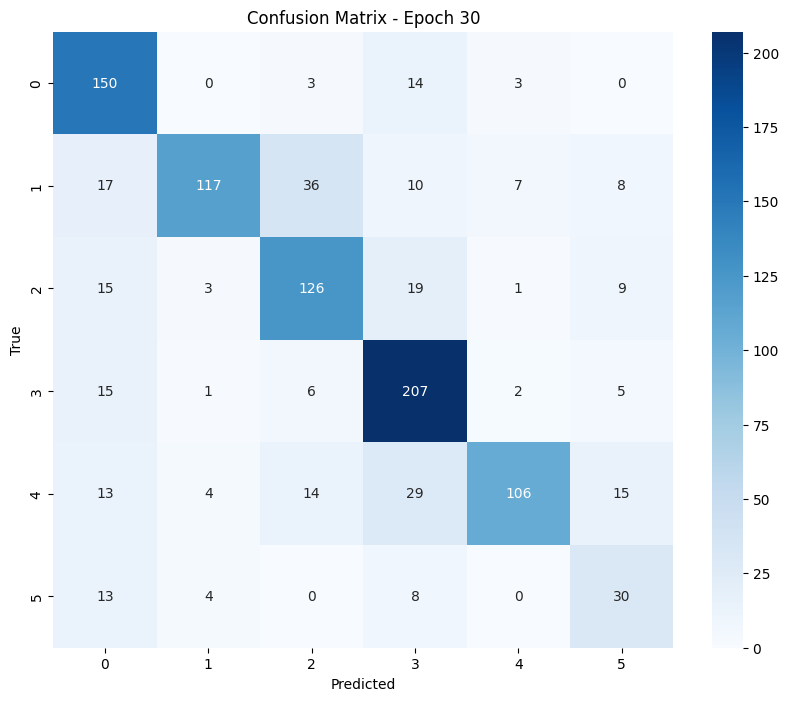

Validating: 100%|██████████| 11/11 [00:11<00:00,  1.08s/it]



Epoch 31/100:
Train Loss: 1.0067, Train Acc: 76.62%
Val Loss: 1.0855, Val Acc: 71.29%


Validating: 100%|██████████| 11/11 [00:12<00:00,  1.13s/it]



Epoch 32/100:
Train Loss: 0.9903, Train Acc: 76.45%
Val Loss: 1.0643, Val Acc: 70.79%


Validating: 100%|██████████| 11/11 [00:11<00:00,  1.04s/it]



Epoch 33/100:
Train Loss: 0.9774, Train Acc: 78.15%
Val Loss: 1.0735, Val Acc: 75.94%


Validating: 100%|██████████| 11/11 [00:11<00:00,  1.04s/it]



Epoch 34/100:
Train Loss: 0.9751, Train Acc: 77.49%
Val Loss: 1.1096, Val Acc: 75.94%


Validating: 100%|██████████| 11/11 [00:11<00:00,  1.08s/it]



Epoch 35/100:
Train Loss: 0.9573, Train Acc: 78.99%
Val Loss: 1.0224, Val Acc: 79.01%


Validating: 100%|██████████| 11/11 [00:11<00:00,  1.07s/it]



Epoch 36/100:
Train Loss: 0.9605, Train Acc: 79.05%
Val Loss: 1.0898, Val Acc: 66.04%


Validating: 100%|██████████| 11/11 [00:11<00:00,  1.05s/it]



Epoch 37/100:
Train Loss: 0.9588, Train Acc: 79.05%
Val Loss: 0.9710, Val Acc: 77.72%


Validating: 100%|██████████| 11/11 [00:11<00:00,  1.06s/it]



Epoch 38/100:
Train Loss: 0.9429, Train Acc: 80.15%
Val Loss: 0.9869, Val Acc: 77.43%


Validating: 100%|██████████| 11/11 [00:11<00:00,  1.07s/it]



Epoch 39/100:
Train Loss: 0.9290, Train Acc: 81.45%
Val Loss: 0.9848, Val Acc: 77.33%


Validating: 100%|██████████| 11/11 [00:12<00:00,  1.15s/it]



Epoch 40/100:
Train Loss: 0.9218, Train Acc: 81.08%
Val Loss: 1.0042, Val Acc: 80.30%


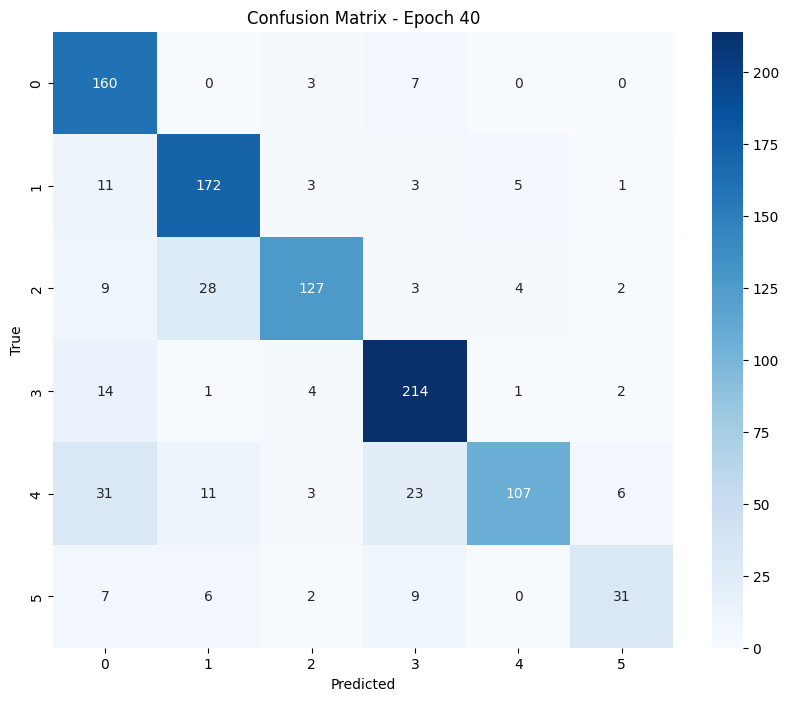

Validating: 100%|██████████| 11/11 [00:12<00:00,  1.10s/it]



Epoch 41/100:
Train Loss: 0.9090, Train Acc: 81.89%
Val Loss: 1.1100, Val Acc: 69.90%


Validating: 100%|██████████| 11/11 [00:11<00:00,  1.08s/it]



Epoch 42/100:
Train Loss: 0.9004, Train Acc: 82.20%
Val Loss: 0.9612, Val Acc: 79.41%


Validating: 100%|██████████| 11/11 [00:11<00:00,  1.05s/it]



Epoch 43/100:
Train Loss: 0.8916, Train Acc: 82.09%
Val Loss: 1.2637, Val Acc: 62.67%


Validating: 100%|██████████| 11/11 [00:11<00:00,  1.07s/it]



Epoch 44/100:
Train Loss: 0.8857, Train Acc: 82.49%
Val Loss: 0.9194, Val Acc: 79.90%


Validating: 100%|██████████| 11/11 [00:11<00:00,  1.01s/it]



Epoch 45/100:
Train Loss: 0.8733, Train Acc: 83.39%
Val Loss: 0.9847, Val Acc: 80.40%


Validating: 100%|██████████| 11/11 [00:11<00:00,  1.02s/it]



Epoch 46/100:
Train Loss: 0.8623, Train Acc: 84.52%
Val Loss: 1.0225, Val Acc: 71.39%


Validating: 100%|██████████| 11/11 [00:11<00:00,  1.07s/it]



Epoch 47/100:
Train Loss: 0.8764, Train Acc: 83.33%
Val Loss: 0.9139, Val Acc: 81.29%


Validating: 100%|██████████| 11/11 [00:12<00:00,  1.12s/it]



Epoch 48/100:
Train Loss: 0.8670, Train Acc: 84.23%
Val Loss: 0.9822, Val Acc: 79.50%


Validating: 100%|██████████| 11/11 [00:11<00:00,  1.09s/it]



Epoch 49/100:
Train Loss: 0.8617, Train Acc: 84.32%
Val Loss: 1.0693, Val Acc: 71.98%


Validating: 100%|██████████| 11/11 [00:11<00:00,  1.08s/it]



Epoch 50/100:
Train Loss: 0.8426, Train Acc: 85.36%
Val Loss: 0.8815, Val Acc: 84.95%


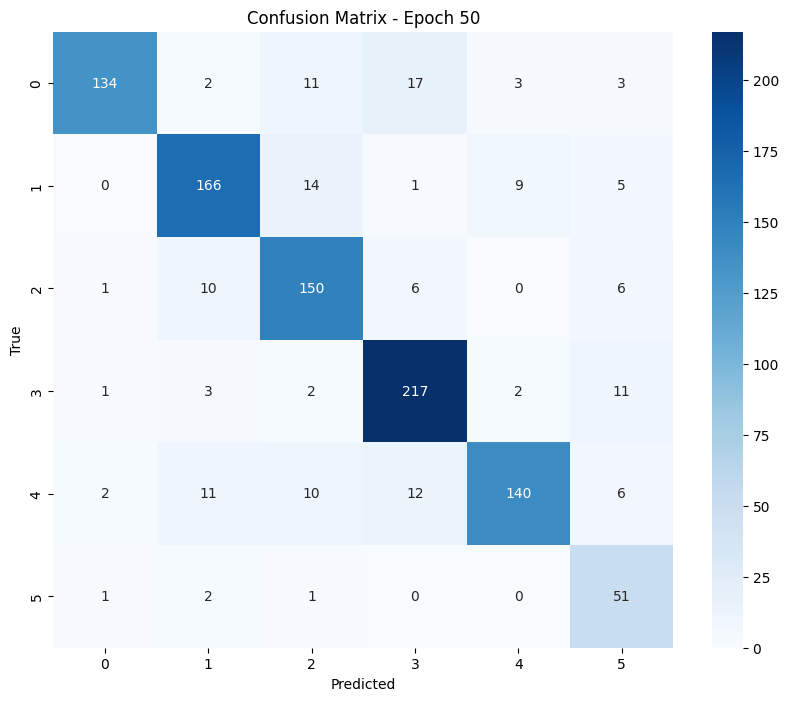

Validating: 100%|██████████| 11/11 [00:12<00:00,  1.11s/it]



Epoch 51/100:
Train Loss: 0.8431, Train Acc: 84.75%
Val Loss: 0.8715, Val Acc: 83.27%


Validating: 100%|██████████| 11/11 [00:11<00:00,  1.08s/it]



Epoch 52/100:
Train Loss: 0.8178, Train Acc: 86.43%
Val Loss: 0.8975, Val Acc: 82.48%


Validating: 100%|██████████| 11/11 [00:11<00:00,  1.06s/it]



Epoch 53/100:
Train Loss: 0.8203, Train Acc: 86.40%
Val Loss: 0.8787, Val Acc: 85.35%


Validating: 100%|██████████| 11/11 [00:11<00:00,  1.05s/it]



Epoch 54/100:
Train Loss: 0.8068, Train Acc: 87.91%
Val Loss: 0.8909, Val Acc: 82.48%


Validating: 100%|██████████| 11/11 [00:11<00:00,  1.04s/it]



Epoch 55/100:
Train Loss: 0.8115, Train Acc: 86.08%
Val Loss: 0.7994, Val Acc: 87.52%


Validating: 100%|██████████| 11/11 [00:11<00:00,  1.08s/it]



Epoch 56/100:
Train Loss: 0.8006, Train Acc: 87.82%
Val Loss: 1.0468, Val Acc: 81.49%


Validating: 100%|██████████| 11/11 [00:11<00:00,  1.05s/it]



Epoch 57/100:
Train Loss: 0.7895, Train Acc: 88.28%
Val Loss: 0.8156, Val Acc: 87.52%


Validating: 100%|██████████| 11/11 [00:11<00:00,  1.00s/it]



Epoch 58/100:
Train Loss: 0.7788, Train Acc: 88.48%
Val Loss: 0.9186, Val Acc: 79.50%


Validating: 100%|██████████| 11/11 [00:11<00:00,  1.09s/it]



Epoch 59/100:
Train Loss: 0.7902, Train Acc: 88.08%
Val Loss: 0.9535, Val Acc: 83.56%


Validating: 100%|██████████| 11/11 [00:11<00:00,  1.05s/it]



Epoch 60/100:
Train Loss: 0.7759, Train Acc: 88.72%
Val Loss: 0.8268, Val Acc: 86.63%


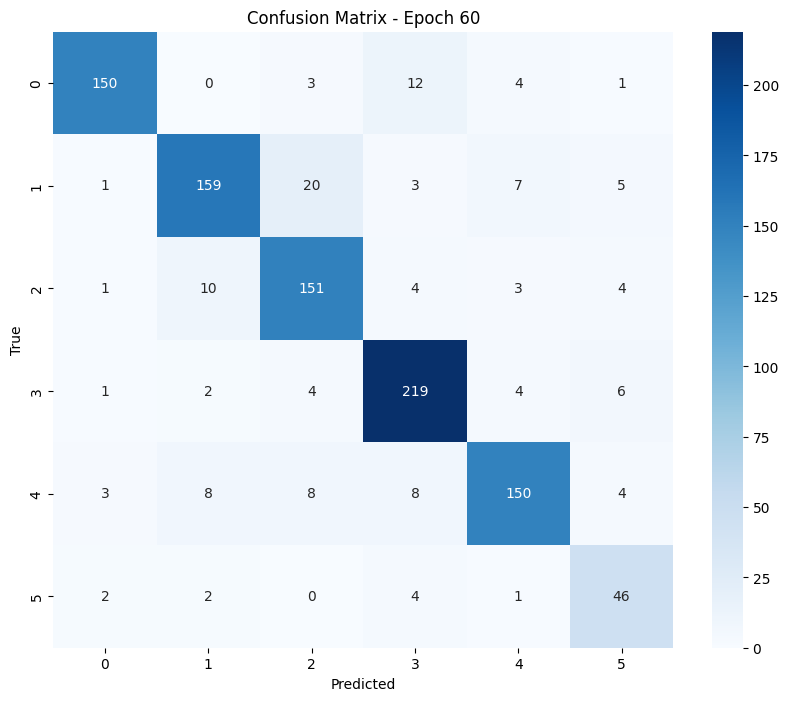

Validating: 100%|██████████| 11/11 [00:11<00:00,  1.02s/it]



Epoch 61/100:
Train Loss: 0.7818, Train Acc: 88.25%
Val Loss: 0.9230, Val Acc: 82.48%


Validating: 100%|██████████| 11/11 [00:11<00:00,  1.02s/it]



Epoch 62/100:
Train Loss: 0.7686, Train Acc: 88.95%
Val Loss: 0.8120, Val Acc: 89.11%


Validating: 100%|██████████| 11/11 [00:11<00:00,  1.06s/it]



Epoch 63/100:
Train Loss: 0.7645, Train Acc: 89.67%
Val Loss: 0.7962, Val Acc: 87.52%


Validating: 100%|██████████| 11/11 [00:11<00:00,  1.01s/it]



Epoch 64/100:
Train Loss: 0.7562, Train Acc: 89.67%
Val Loss: 0.9020, Val Acc: 80.10%


Validating: 100%|██████████| 11/11 [00:11<00:00,  1.02s/it]



Epoch 65/100:
Train Loss: 0.7417, Train Acc: 90.62%
Val Loss: 0.8234, Val Acc: 84.06%


Validating: 100%|██████████| 11/11 [00:11<00:00,  1.06s/it]



Epoch 66/100:
Train Loss: 0.7299, Train Acc: 91.93%
Val Loss: 1.0216, Val Acc: 81.68%


Validating: 100%|██████████| 11/11 [00:12<00:00,  1.11s/it]



Epoch 67/100:
Train Loss: 0.7287, Train Acc: 91.23%
Val Loss: 0.7858, Val Acc: 88.12%


Validating: 100%|██████████| 11/11 [00:12<00:00,  1.10s/it]



Epoch 68/100:
Train Loss: 0.7372, Train Acc: 91.20%
Val Loss: 0.8200, Val Acc: 87.82%


Validating: 100%|██████████| 11/11 [00:11<00:00,  1.05s/it]



Epoch 69/100:
Train Loss: 0.7263, Train Acc: 91.96%
Val Loss: 0.8868, Val Acc: 83.96%


Validating: 100%|██████████| 11/11 [00:11<00:00,  1.03s/it]



Epoch 70/100:
Train Loss: 0.7255, Train Acc: 91.32%
Val Loss: 0.8014, Val Acc: 88.61%


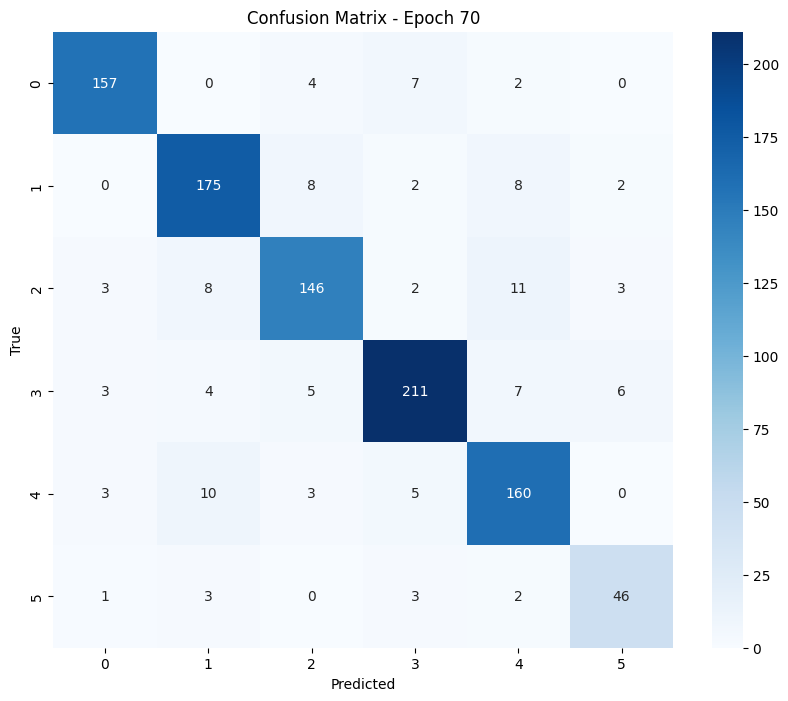

Validating: 100%|██████████| 11/11 [00:12<00:00,  1.12s/it]



Epoch 71/100:
Train Loss: 0.7196, Train Acc: 91.90%
Val Loss: 0.7785, Val Acc: 88.91%


Validating: 100%|██████████| 11/11 [00:11<00:00,  1.04s/it]



Epoch 72/100:
Train Loss: 0.7056, Train Acc: 92.45%
Val Loss: 0.7852, Val Acc: 88.61%


Validating: 100%|██████████| 11/11 [00:11<00:00,  1.05s/it]



Epoch 73/100:
Train Loss: 0.6992, Train Acc: 93.03%
Val Loss: 0.8200, Val Acc: 87.03%


Validating: 100%|██████████| 11/11 [00:11<00:00,  1.04s/it]



Epoch 74/100:
Train Loss: 0.6953, Train Acc: 93.32%
Val Loss: 0.7630, Val Acc: 90.00%


Validating: 100%|██████████| 11/11 [00:12<00:00,  1.09s/it]



Epoch 75/100:
Train Loss: 0.6852, Train Acc: 94.10%
Val Loss: 0.8174, Val Acc: 87.82%


Validating: 100%|██████████| 11/11 [00:11<00:00,  1.02s/it]



Epoch 76/100:
Train Loss: 0.6898, Train Acc: 93.40%
Val Loss: 0.7549, Val Acc: 91.58%


Validating: 100%|██████████| 11/11 [00:11<00:00,  1.03s/it]



Epoch 77/100:
Train Loss: 0.6796, Train Acc: 94.36%
Val Loss: 0.7492, Val Acc: 91.09%


Validating: 100%|██████████| 11/11 [00:11<00:00,  1.07s/it]



Epoch 78/100:
Train Loss: 0.6855, Train Acc: 94.24%
Val Loss: 0.7625, Val Acc: 89.60%


Validating: 100%|██████████| 11/11 [00:11<00:00,  1.06s/it]



Epoch 79/100:
Train Loss: 0.6775, Train Acc: 94.21%
Val Loss: 0.7428, Val Acc: 90.99%


Validating: 100%|██████████| 11/11 [00:11<00:00,  1.02s/it]



Epoch 80/100:
Train Loss: 0.6692, Train Acc: 94.91%
Val Loss: 0.7848, Val Acc: 90.30%


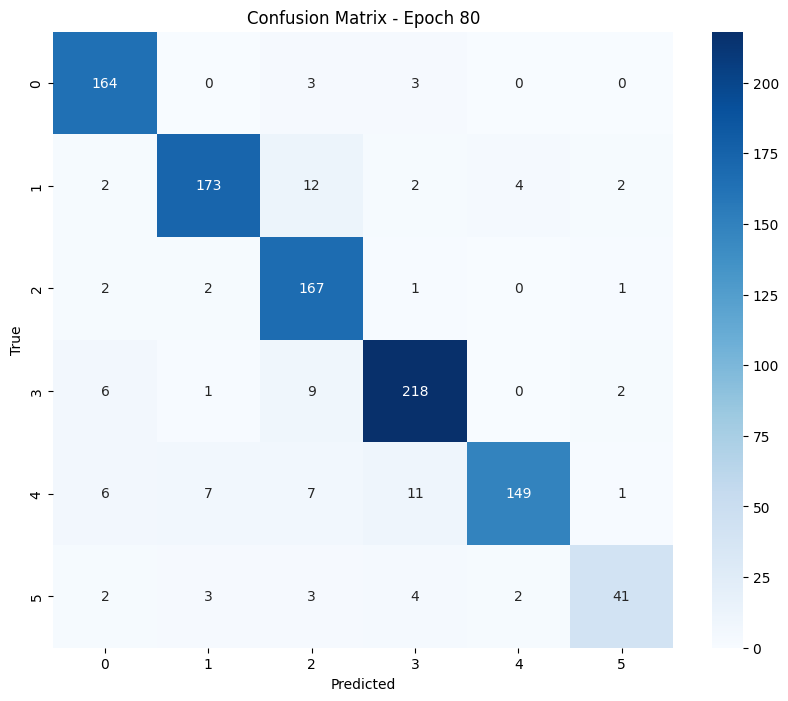

Validating: 100%|██████████| 11/11 [00:11<00:00,  1.01s/it]



Epoch 81/100:
Train Loss: 0.6706, Train Acc: 94.39%
Val Loss: 0.7745, Val Acc: 90.10%


Validating: 100%|██████████| 11/11 [00:11<00:00,  1.04s/it]



Epoch 82/100:
Train Loss: 0.6575, Train Acc: 95.57%
Val Loss: 0.7490, Val Acc: 91.68%


Validating: 100%|██████████| 11/11 [00:11<00:00,  1.02s/it]



Epoch 83/100:
Train Loss: 0.6645, Train Acc: 94.85%
Val Loss: 0.7304, Val Acc: 91.19%


Validating: 100%|██████████| 11/11 [00:11<00:00,  1.07s/it]



Epoch 84/100:
Train Loss: 0.6562, Train Acc: 95.14%
Val Loss: 0.7255, Val Acc: 92.08%


Validating: 100%|██████████| 11/11 [00:11<00:00,  1.08s/it]



Epoch 85/100:
Train Loss: 0.6550, Train Acc: 96.09%
Val Loss: 0.7266, Val Acc: 92.08%


Validating: 100%|██████████| 11/11 [00:11<00:00,  1.06s/it]



Epoch 86/100:
Train Loss: 0.6496, Train Acc: 95.80%
Val Loss: 0.7147, Val Acc: 92.18%


Validating: 100%|██████████| 11/11 [00:11<00:00,  1.05s/it]



Epoch 87/100:
Train Loss: 0.6453, Train Acc: 96.30%
Val Loss: 0.7071, Val Acc: 92.57%


Validating: 100%|██████████| 11/11 [00:11<00:00,  1.03s/it]



Epoch 88/100:
Train Loss: 0.6477, Train Acc: 95.95%
Val Loss: 0.7345, Val Acc: 92.18%


Validating: 100%|██████████| 11/11 [00:12<00:00,  1.10s/it]



Epoch 89/100:
Train Loss: 0.6415, Train Acc: 96.30%
Val Loss: 0.7141, Val Acc: 92.97%


Validating: 100%|██████████| 11/11 [00:12<00:00,  1.09s/it]



Epoch 90/100:
Train Loss: 0.6412, Train Acc: 96.41%
Val Loss: 0.7017, Val Acc: 92.48%


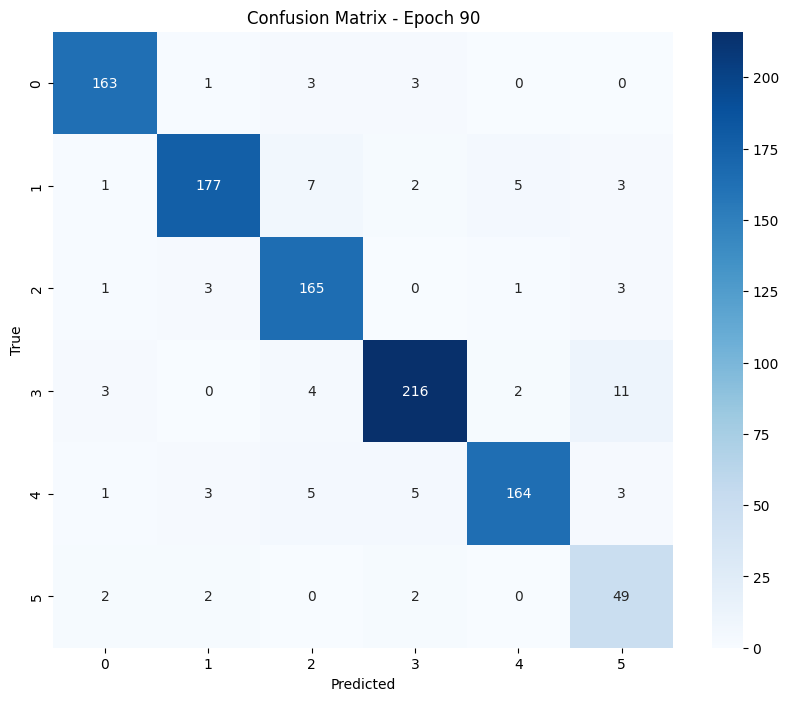

Validating: 100%|██████████| 11/11 [00:11<00:00,  1.05s/it]



Epoch 91/100:
Train Loss: 0.6477, Train Acc: 95.78%
Val Loss: 0.7086, Val Acc: 93.07%


Validating: 100%|██████████| 11/11 [00:12<00:00,  1.11s/it]



Epoch 92/100:
Train Loss: 0.6383, Train Acc: 96.33%
Val Loss: 0.7070, Val Acc: 92.67%


Validating: 100%|██████████| 11/11 [00:11<00:00,  1.08s/it]



Epoch 93/100:
Train Loss: 0.6446, Train Acc: 96.01%
Val Loss: 0.7027, Val Acc: 92.77%


Validating: 100%|██████████| 11/11 [00:11<00:00,  1.09s/it]



Epoch 94/100:
Train Loss: 0.6341, Train Acc: 96.79%
Val Loss: 0.7068, Val Acc: 92.57%


Validating: 100%|██████████| 11/11 [00:11<00:00,  1.09s/it]



Epoch 95/100:
Train Loss: 0.6461, Train Acc: 96.06%
Val Loss: 0.7009, Val Acc: 93.47%


Validating: 100%|██████████| 11/11 [00:10<00:00,  1.00it/s]



Epoch 96/100:
Train Loss: 0.6365, Train Acc: 96.27%
Val Loss: 0.7031, Val Acc: 93.17%


Validating: 100%|██████████| 11/11 [00:11<00:00,  1.05s/it]



Epoch 97/100:
Train Loss: 0.6331, Train Acc: 96.90%
Val Loss: 0.7037, Val Acc: 92.77%


Validating: 100%|██████████| 11/11 [00:11<00:00,  1.07s/it]



Epoch 98/100:
Train Loss: 0.6382, Train Acc: 96.38%
Val Loss: 0.7043, Val Acc: 92.97%


Validating: 100%|██████████| 11/11 [00:11<00:00,  1.09s/it]



Epoch 99/100:
Train Loss: 0.6384, Train Acc: 96.76%
Val Loss: 0.7014, Val Acc: 93.17%


Validating: 100%|██████████| 11/11 [00:12<00:00,  1.11s/it]



Epoch 100/100:
Train Loss: 0.6379, Train Acc: 96.24%
Val Loss: 0.6978, Val Acc: 92.97%


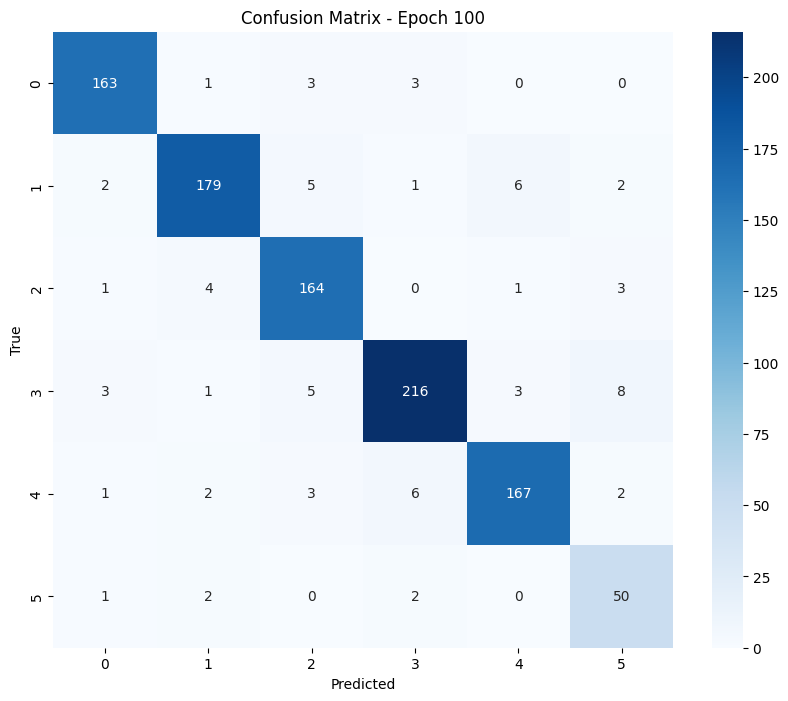

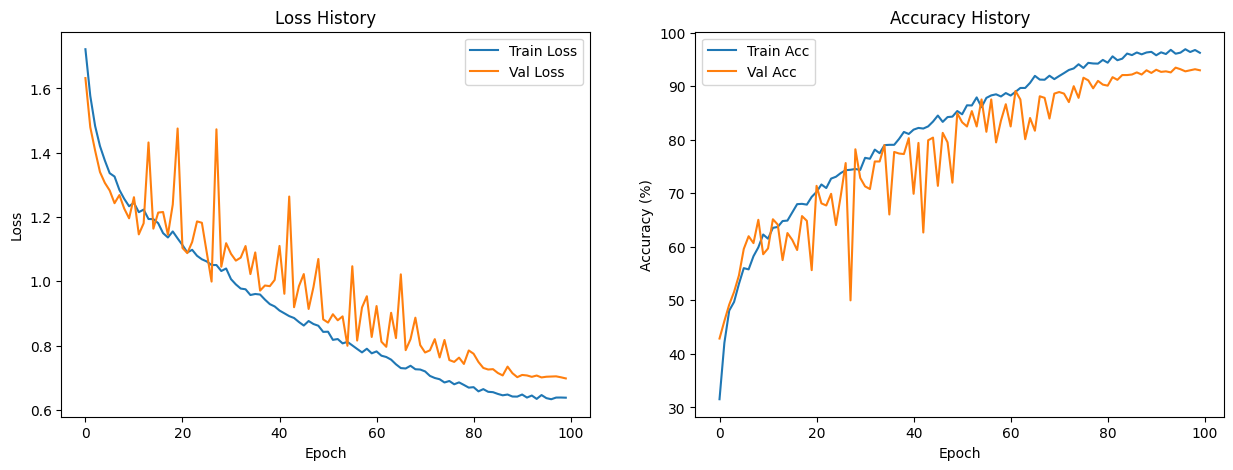

In [14]:
# First check available GPUs
n_available_gpus = torch.cuda.device_count()
print(f"Available GPUs: {n_available_gpus}")

# Setup GPU devices based on availability
GPUS_TO_USE = list(range(n_available_gpus))  # This will get all available GPUs
n_gpus = len(GPUS_TO_USE)
device = f'cuda:{GPUS_TO_USE[0]}'  # Primary GPU is 0
torch.cuda.set_device(GPUS_TO_USE[0])

print(f"Using {n_gpus} GPUs: {GPUS_TO_USE}")

# Model initialization with multi-GPU support
model = ImprovedTrashNet()
model = model.to(device)
if n_gpus > 1:
    try:
        model = torch.nn.DataParallel(model, device_ids=GPUS_TO_USE)
        print("Successfully initialized DataParallel")
    except Exception as e:
        print(f"Error setting up DataParallel: {e}")
        # Fallback to single GPU if DataParallel fails
        model = model.to(device)
        n_gpus = 1
        print("Falling back to single GPU")

# Adjust batch size based on available GPUs
batch_size_per_gpu = 32
batch_size = batch_size_per_gpu * n_gpus
initial_lr = 0.0001 * (n_gpus/3)  # Scale learning rate with number of GPUs
max_lr = initial_lr * 8
num_epochs = 100
print(f"Total batch size: {batch_size}")
print(f"Initial learning rate: {initial_lr}")
weight_decay = 0.0005
patience = 15

train_loader = DataLoader(
    train_dataset,
    batch_size=batch_size,
    shuffle=True,
    num_workers=24,
    pin_memory=True,
    drop_last=True
)

val_loader = DataLoader(
    val_dataset,
    batch_size=batch_size,
    shuffle=False,
    num_workers=24,
    pin_memory=True
)

class_counts = torch.bincount(torch.tensor([y for _, y in train_dataset]))
weights = 1. / class_counts.float()
weights = weights / weights.sum()
weights = weights.to(device)

criterion = nn.CrossEntropyLoss(weight=weights, label_smoothing=0.1)

optimizer = optim.AdamW(model.parameters(), lr=initial_lr, weight_decay=weight_decay)
scheduler = optim.lr_scheduler.OneCycleLR(
    optimizer,
    max_lr=max_lr,
    div_factor=25,
    final_div_factor=1000,
    epochs=num_epochs,
    steps_per_epoch=len(train_loader)
)

def train_epoch(model, loader, criterion, optimizer, scheduler, epoch):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    
    pbar = tqdm(loader, desc=f'Epoch {epoch+1}/{num_epochs}')
    for batch_idx, (images, targets) in enumerate(pbar):
        images, targets = images.to(device), targets.to(device)
        
        # Forward pass
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, targets)
        
        # Backward pass with gradient clipping
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()
        scheduler.step()
        
        # Statistics
        running_loss += loss.item()
        _, predicted = outputs.max(1)
        total += targets.size(0)
        correct += predicted.eq(targets).sum().item()
        
        # Update progress bar
        acc = 100. * correct / total
        pbar.set_postfix({
            'loss': f'{loss.item():.4f}',
            'acc': f'{acc:.2f}%',
            'lr': f'{scheduler.get_last_lr()[0]:.6f}'
        })
    
    epoch_loss = running_loss / len(loader)
    epoch_acc = 100. * correct / total
    return epoch_loss, epoch_acc

def validate(model, loader, criterion):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0
    all_preds = []
    all_targets = []
    
    with torch.no_grad():
        for images, targets in tqdm(loader, desc='Validating'):
            images, targets = images.to(device), targets.to(device)
            
            outputs = model(images)
            loss = criterion(outputs, targets)
            
            running_loss += loss.item()
            _, predicted = outputs.max(1)
            total += targets.size(0)
            correct += predicted.eq(targets).sum().item()
            
            all_preds.extend(predicted.cpu().numpy())
            all_targets.extend(targets.cpu().numpy())
    
    val_loss = running_loss / len(loader)
    val_acc = 100. * correct / total
    return val_loss, val_acc, all_preds, all_targets

def save_checkpoint(model, optimizer, scheduler, epoch, metrics, filename):
    checkpoint = {
        'epoch': epoch,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'scheduler_state_dict': scheduler.state_dict(),
        'metrics': metrics
    }
    torch.save(checkpoint, filename)

# Training execution
print("Starting training...")
train_losses = []
train_accs = []
val_losses = []
val_accs = []
best_val_acc = 0
early_stopping_counter = 0
min_val_loss = float('inf')

for epoch in range(num_epochs):
    # Training phase
    train_loss, train_acc = train_epoch(model, train_loader, criterion, 
                                      optimizer, scheduler, epoch)
    train_losses.append(train_loss)
    train_accs.append(train_acc)
    
    # Validation phase
    val_loss, val_acc, preds, targets = validate(model, val_loader, criterion)
    val_losses.append(val_loss)
    val_accs.append(val_acc)
    
    # Print epoch summary
    print(f'\nEpoch {epoch+1}/{num_epochs}:')
    print(f'Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}%')
    print(f'Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.2f}%')
    
    # Save best model
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        metrics = {
            'train_loss': train_loss,
            'train_acc': train_acc,
            'val_loss': val_loss,
            'val_acc': val_acc,
            'best_val_acc': best_val_acc
        }
        save_checkpoint(model, optimizer, scheduler, epoch, metrics, 'best_model_v2.pth')
        early_stopping_counter = 0
    else:
        early_stopping_counter += 1
    
    # Early stopping check
    if early_stopping_counter >= patience:
        print(f'\nEarly stopping triggered after {epoch+1} epochs')
        break
    
    # Plot confusion matrix every 10 epochs
    if (epoch + 1) % 10 == 0:
        cm = confusion_matrix(targets, preds)
        plt.figure(figsize=(10, 8))
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
        plt.title(f'Confusion Matrix - Epoch {epoch+1}')
        plt.xlabel('Predicted')
        plt.ylabel('True')
        plt.show()

# Plot final training curves
plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Val Loss')
plt.title('Loss History')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(train_accs, label='Train Acc')
plt.plot(val_accs, label='Val Acc')
plt.title('Accuracy History')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.legend()
plt.show()

## Model Analysis and Insights


Successfully loaded model checkpoint
Successfully loaded optimizer and scheduler states

Best model metrics when saved:
train_loss: 0.6461
train_acc: 96.0648
val_loss: 0.7009
val_acc: 93.4653
best_val_acc: 93.4653


Validating:   0%|          | 0/6 [00:00<?, ?it/s]

Validating: 100%|██████████| 6/6 [00:11<00:00,  1.90s/it]


Final Test Results:
Test Loss: 0.7125
Test Accuracy: 92.31%


Accuracy of cardboard: 96.34%
Accuracy of glass: 86.67%
Accuracy of metal: 95.12%
Accuracy of paper: 92.37%
Accuracy of plastic: 92.13%
Accuracy of trash: 93.55%


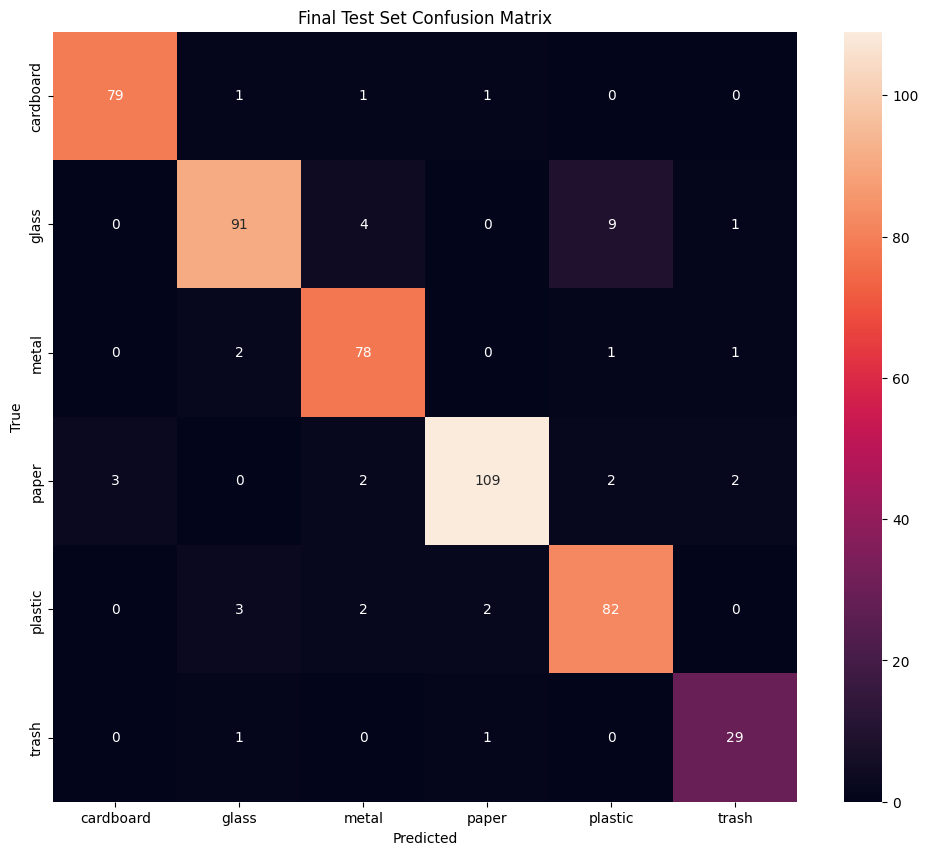


Key Findings and Insights:
1. Model Performance:
   - Best validation accuracy: 93.47%
   - Final test accuracy: 92.31%

2. Per-class Performance Analysis:
   - cardboard: 96.34%
   - glass: 86.67%
   - metal: 95.12%
   - paper: 92.37%
   - plastic: 92.13%
   - trash: 93.55%

3. Identified Challenges:
Most commonly confused classes:
   - glass mistaken as plastic: 8.57%
   - glass mistaken as metal: 3.81%
   - plastic mistaken as glass: 3.37%

4. Model Bias Analysis:
   - Class imbalance impact:
   - cardboard: 82 samples, 96.34% accuracy
   - glass: 105 samples, 86.67% accuracy
   - metal: 82 samples, 95.12% accuracy
   - paper: 118 samples, 92.37% accuracy
   - plastic: 89 samples, 92.13% accuracy
   - trash: 31 samples, 93.55% accuracy

5. Sample Error Analysis:
Error 1:
   True class: glass
   Predicted: plastic
Error 2:
   True class: glass
   Predicted: plastic
Error 3:
   True class: glass
   Predicted: plastic
Error 4:
   True class: cardboard
   Predicted: paper
Error 5:
   T

: 

In [ ]:
# Load best model for final analysis - with weights_only=True for security
checkpoint = torch.load('best_model_v2.pth', weights_only=True)

# If you get any loading issues, you might need to restructure the loading like this:
try:
    # Try loading with weights_only first
    checkpoint = torch.load('best_model_v2.pth', weights_only=True)
    model.load_state_dict(checkpoint['model_state_dict'])
except Exception as e:
    print(f"First loading attempt failed: {e}")
    print("Trying alternative loading method...")
    try:
        # Fallback to legacy loading if needed
        checkpoint = torch.load('best_model_v2.pth', map_location=device)
        model.load_state_dict(checkpoint['model_state_dict'])
    except Exception as e:
        print(f"Both loading attempts failed: {e}")
        raise e

print("\nSuccessfully loaded model checkpoint")

# Optionally load optimizer and scheduler if needed
# Note: These might not be available with weights_only=True
try:
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    scheduler.load_state_dict(checkpoint['scheduler_state_dict'])
    print("Successfully loaded optimizer and scheduler states")
except KeyError:
    print("Note: Optimizer and scheduler states were not loaded (not available in weights_only mode)")

# Print available metrics
if 'metrics' in checkpoint:
    print("\nBest model metrics when saved:")
    for key, value in checkpoint['metrics'].items():
        if isinstance(value, float):
            print(f"{key}: {value:.4f}")
        else:
            print(f"{key}: {value}")

# Evaluate on test set
test_loader = DataLoader(
    test_dataset,
    batch_size=batch_size,
    shuffle=False,
    num_workers=24,
    pin_memory=True
)

test_loss, test_acc, test_preds, test_targets = validate(model, test_loader, criterion)
print(f"\nFinal Test Results:")
print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_acc:.2f}%")

# Per-class accuracy analysis
class_names = ['cardboard', 'glass', 'metal', 'paper', 'plastic', 'trash']
class_correct = list(0. for i in range(6))
class_total = list(0. for i in range(6))

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        c = (predicted == labels).squeeze()
        for i in range(len(labels)):
            label = labels[i]
            class_correct[label] += c[i].item()
            class_total[label] += 1

for i in range(6):
    print(f'Accuracy of {class_names[i]}: {100 * class_correct[i] / class_total[i]:.2f}%')

# Confusion matrix visualization
cm = confusion_matrix(test_targets, test_preds)
plt.figure(figsize=(12, 10))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=class_names, yticklabels=class_names)
plt.title('Final Test Set Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

# Additional insights and analysis
print("\nKey Findings and Insights:")
print("1. Model Performance:")
print(f"   - Best validation accuracy: {best_val_acc:.2f}%")
print(f"   - Final test accuracy: {test_acc:.2f}%")
print("\n2. Per-class Performance Analysis:")
for i in range(6):
    print(f"   - {class_names[i]}: {100 * class_correct[i] / class_total[i]:.2f}%")

print("\n3. Identified Challenges:")
# Calculate confusion rates
confusion_rates = cm / cm.sum(axis=1)[:, np.newaxis]
most_confused = []
for i in range(len(class_names)):
    for j in range(len(class_names)):
        if i != j:
            most_confused.append((class_names[i], class_names[j], confusion_rates[i, j]))

# Sort and print top confused pairs
most_confused.sort(key=lambda x: x[2], reverse=True)
print("Most commonly confused classes:")
for true_class, pred_class, rate in most_confused[:3]:
    print(f"   - {true_class} mistaken as {pred_class}: {rate*100:.2f}%")

print("\n4. Model Bias Analysis:")
print("   - Class imbalance impact:")
for i, name in enumerate(class_names):
    total = cm[i].sum()
    correct = cm[i, i]
    print(f"   - {name}: {total} samples, {correct/total*100:.2f}% accuracy")

# Error Analysis
def analyze_errors(model, loader, num_samples=5):
    model.eval()
    errors = []
    
    with torch.no_grad():
        for images, labels in loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = outputs.max(1)
            
            # Find incorrect predictions
            incorrect_mask = predicted != labels
            if incorrect_mask.any():
                incorrect_images = images[incorrect_mask]
                incorrect_labels = labels[incorrect_mask]
                incorrect_preds = predicted[incorrect_mask]
                
                for img, true_label, pred_label in zip(incorrect_images, 
                                                     incorrect_labels, 
                                                     incorrect_preds):
                    errors.append({
                        'image': img.cpu(),
                        'true': class_names[true_label],
                        'predicted': class_names[pred_label]
                    })
                    
            if len(errors) >= num_samples:
                break
    
    return errors[:num_samples]

print("\n5. Sample Error Analysis:")
errors = analyze_errors(model, test_loader)
for i, error in enumerate(errors, 1):
    print(f"Error {i}:")
    print(f"   True class: {error['true']}")
    print(f"   Predicted: {error['predicted']}")


## Recommendations for Improvement


Based on our analysis, here are key recommendations for improving the model:

1. Data Augmentation:
   - Implement more aggressive augmentation for underrepresented classes
   - Add random lighting changes to improve robustness
   - Consider adding random backgrounds to reduce background bias

2. Architecture Improvements:
   - Add attention mechanisms to focus on distinguishing features
   - Increase model capacity for commonly confused classes
   - Implement feature pyramid network for better scale handling

3. Training Strategy:
   - Use weighted sampling to address class imbalance
   - Implement curriculum learning for difficult cases
   - Add mixup or cutmix augmentation

4. Dataset Improvements:
   - Collect more samples for underrepresented classes
   - Add edge cases for commonly confused categories
   - Include more variety in lighting and background conditions